# Import Libraries & Set Up
---

In [1]:
import warnings
import logging
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import bnlearn as bn
from pgmpy.global_vars import logger
from utils import * # Helper functions

In [2]:
warnings.filterwarnings('ignore')
logger.setLevel(logging.ERROR)
logging.getLogger('seaborn').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('pandas').setLevel(logging.ERROR)

palette = ['#800080', '#8A2BE2', '#FF69B4', '#DA70D6', '#9370DB', '#DDA0DD', '#BA55D3']
gradient_palette = sns.light_palette('#620080', as_cmap=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
sns.set_theme(style="whitegrid", palette=palette)

# Dementia
---

Let's import the processed dataset.

In [3]:
dementia_df = pd.read_csv('data/dementia_data_processed.csv')

## Discretising the Data
---

To prepare the data for a discrete BN, we must first discretise the data into bins.

In [4]:
dementia_df_5bins = discretise(dementia_df.copy(), nbins=5)
dementia_df_sturges = discretise(dementia_df.copy(), method='sturges')
dementia_df_freedman_diaconis = discretise(dementia_df.copy(), method='freedman-diaconis')

Then we can plot this discretised data to see the effects.

### 5 Bin Discretisation
---

In [5]:
dementia_df_5bins.head()

Visit MR Delay M/F Age EDUC SES MMSE CDR eTIV nWBV ASF Group
0     1        1   4   1    1   1    2   2    2    0   2     1
1     0        0   4   1    2   3    4   0    0    1   3     0
2     0        0   0   1    2   2    4   1    1    2   2     1
3     0        0   4   1    2   1    4   0    1    2   2     0
4     0        0   0   1    1   3    4   0    2    2   2     0

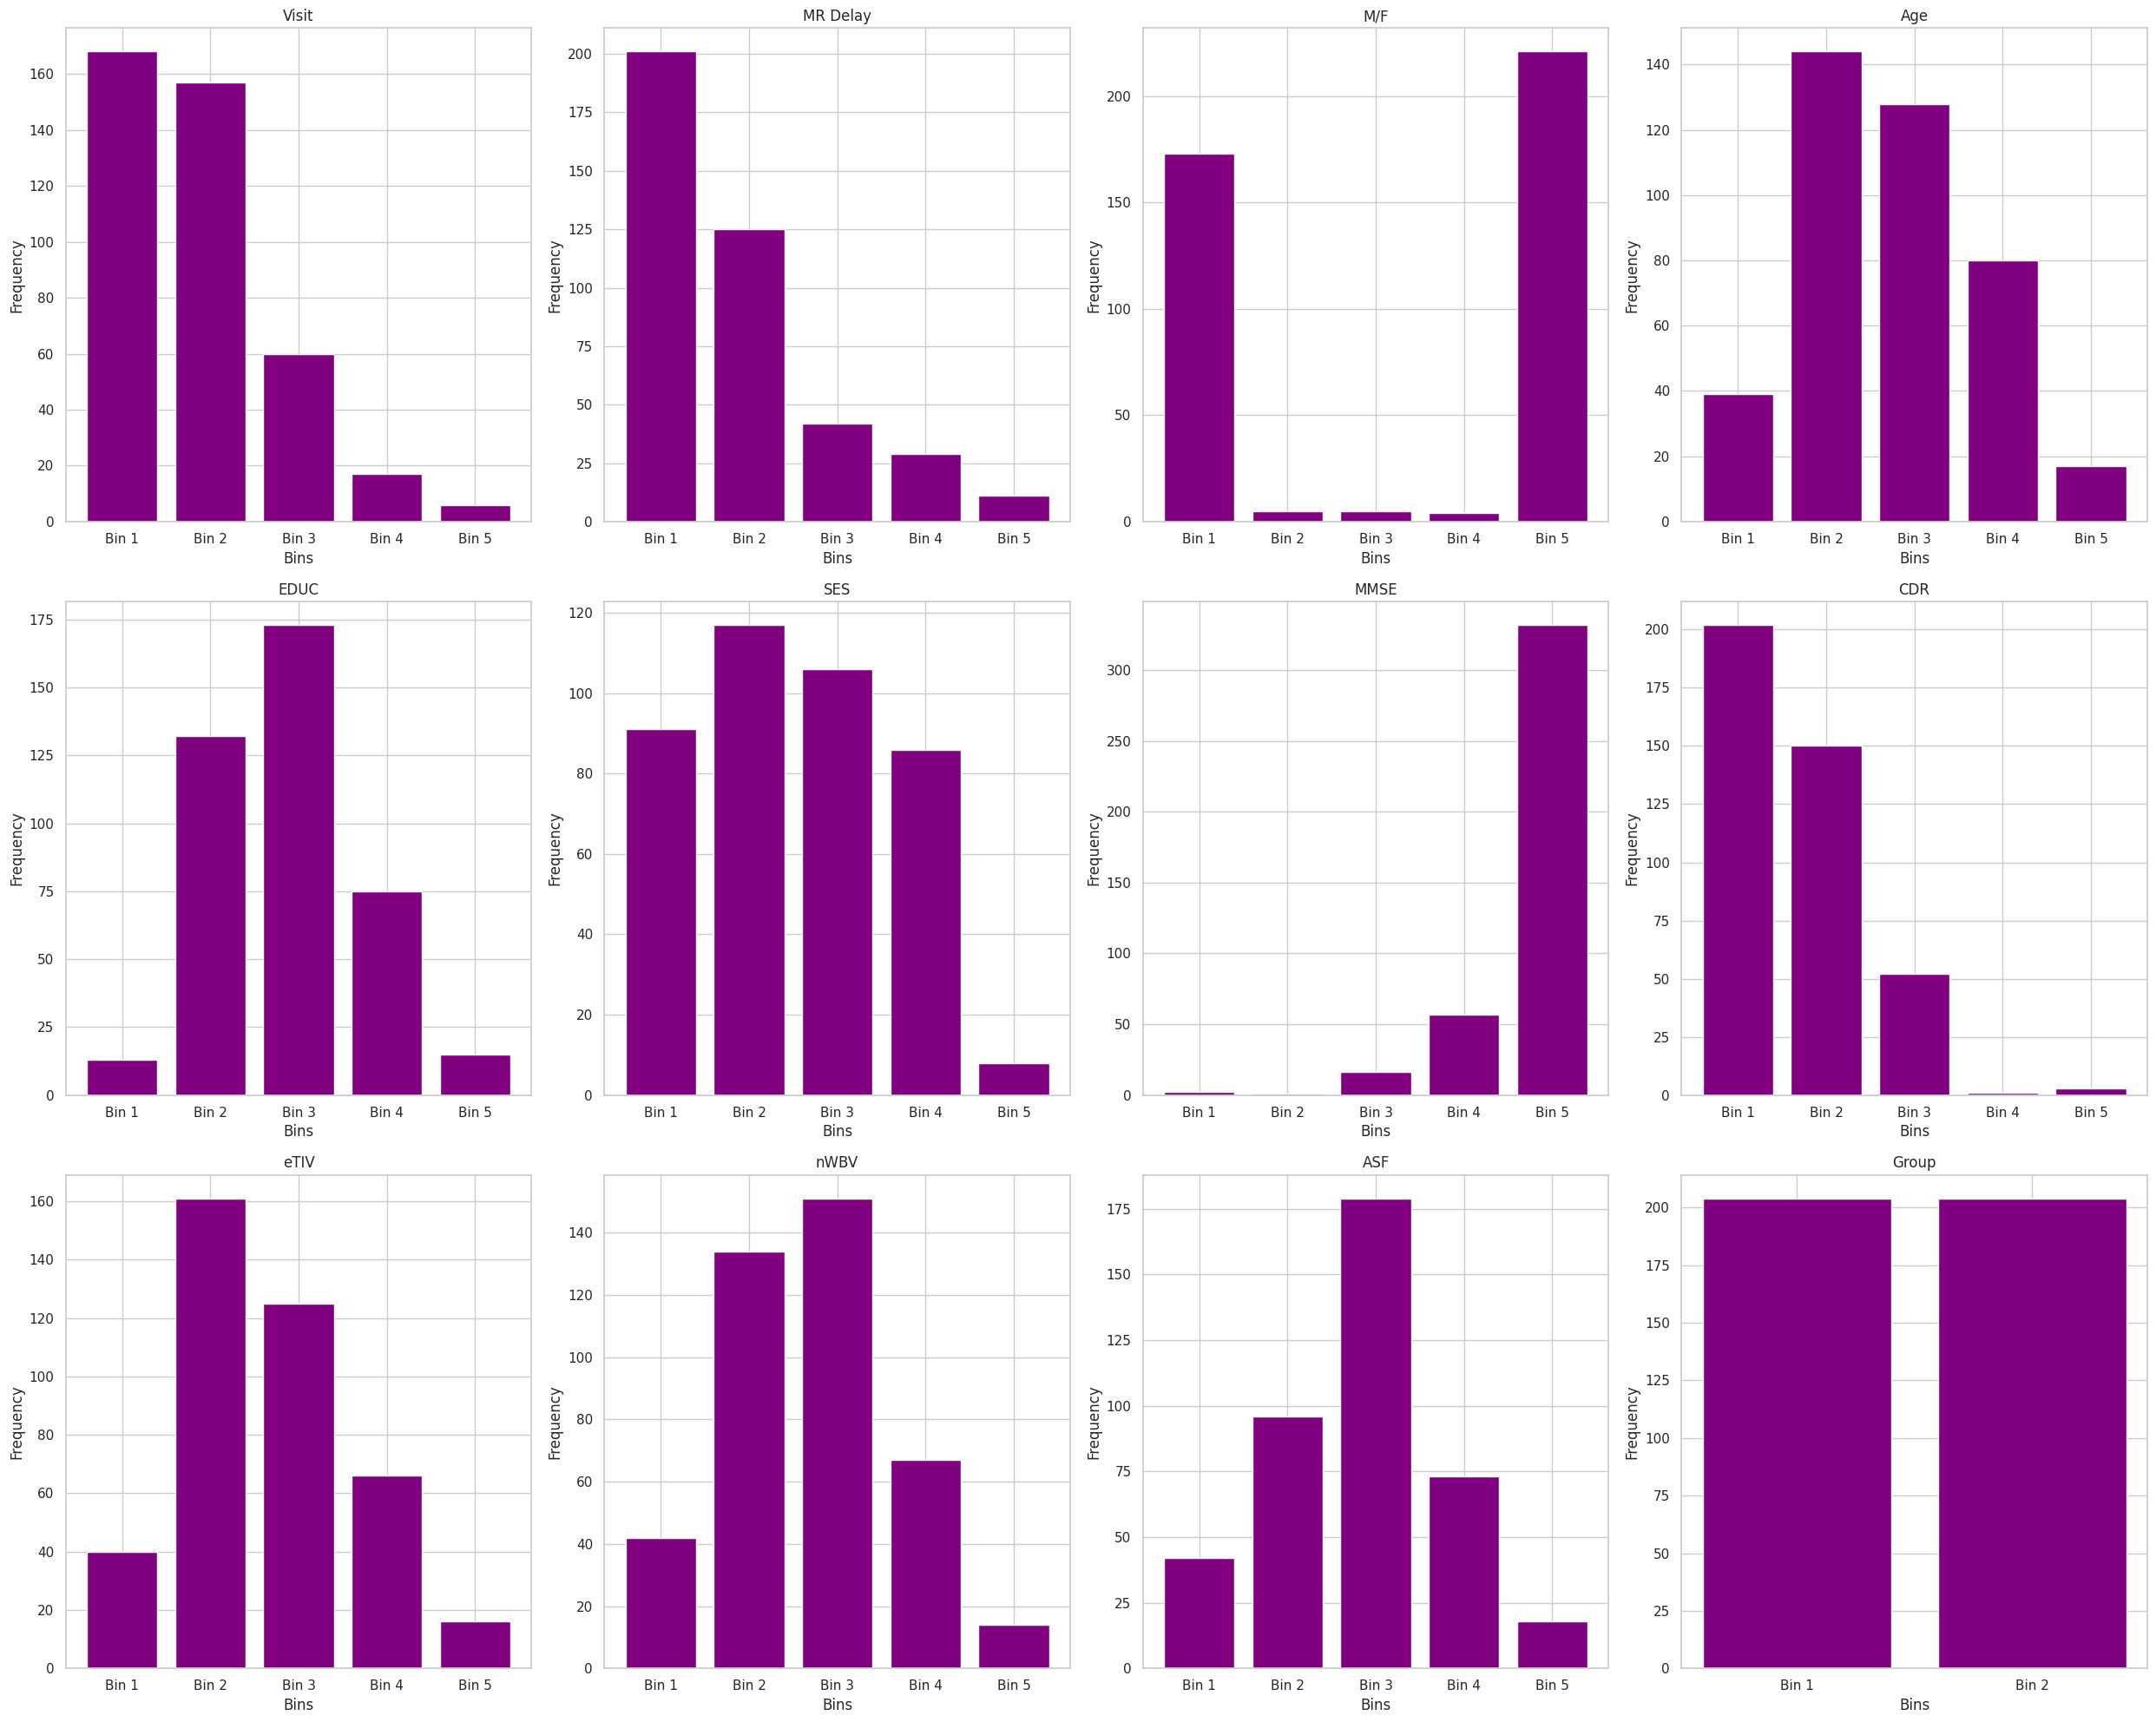

In [6]:
plot_bins_barcharts(dementia_df_5bins)

### Sturges Formula Discretisation
---

In [7]:
dementia_df_sturges.head()

Visit MR Delay M/F Age EDUC SES MMSE CDR eTIV nWBV ASF Group
0     2        2   9   3    3   2    5   4    4    0   4     1
1     0        0   9   3    5   7    9   0    1    2   7     0
2     0        0   0   2    5   4    9   2    2    5   5     1
3     0        0   9   2    4   2    9   0    3    5   4     0
4     0        0   0   3    3   7    9   0    4    4   4     0

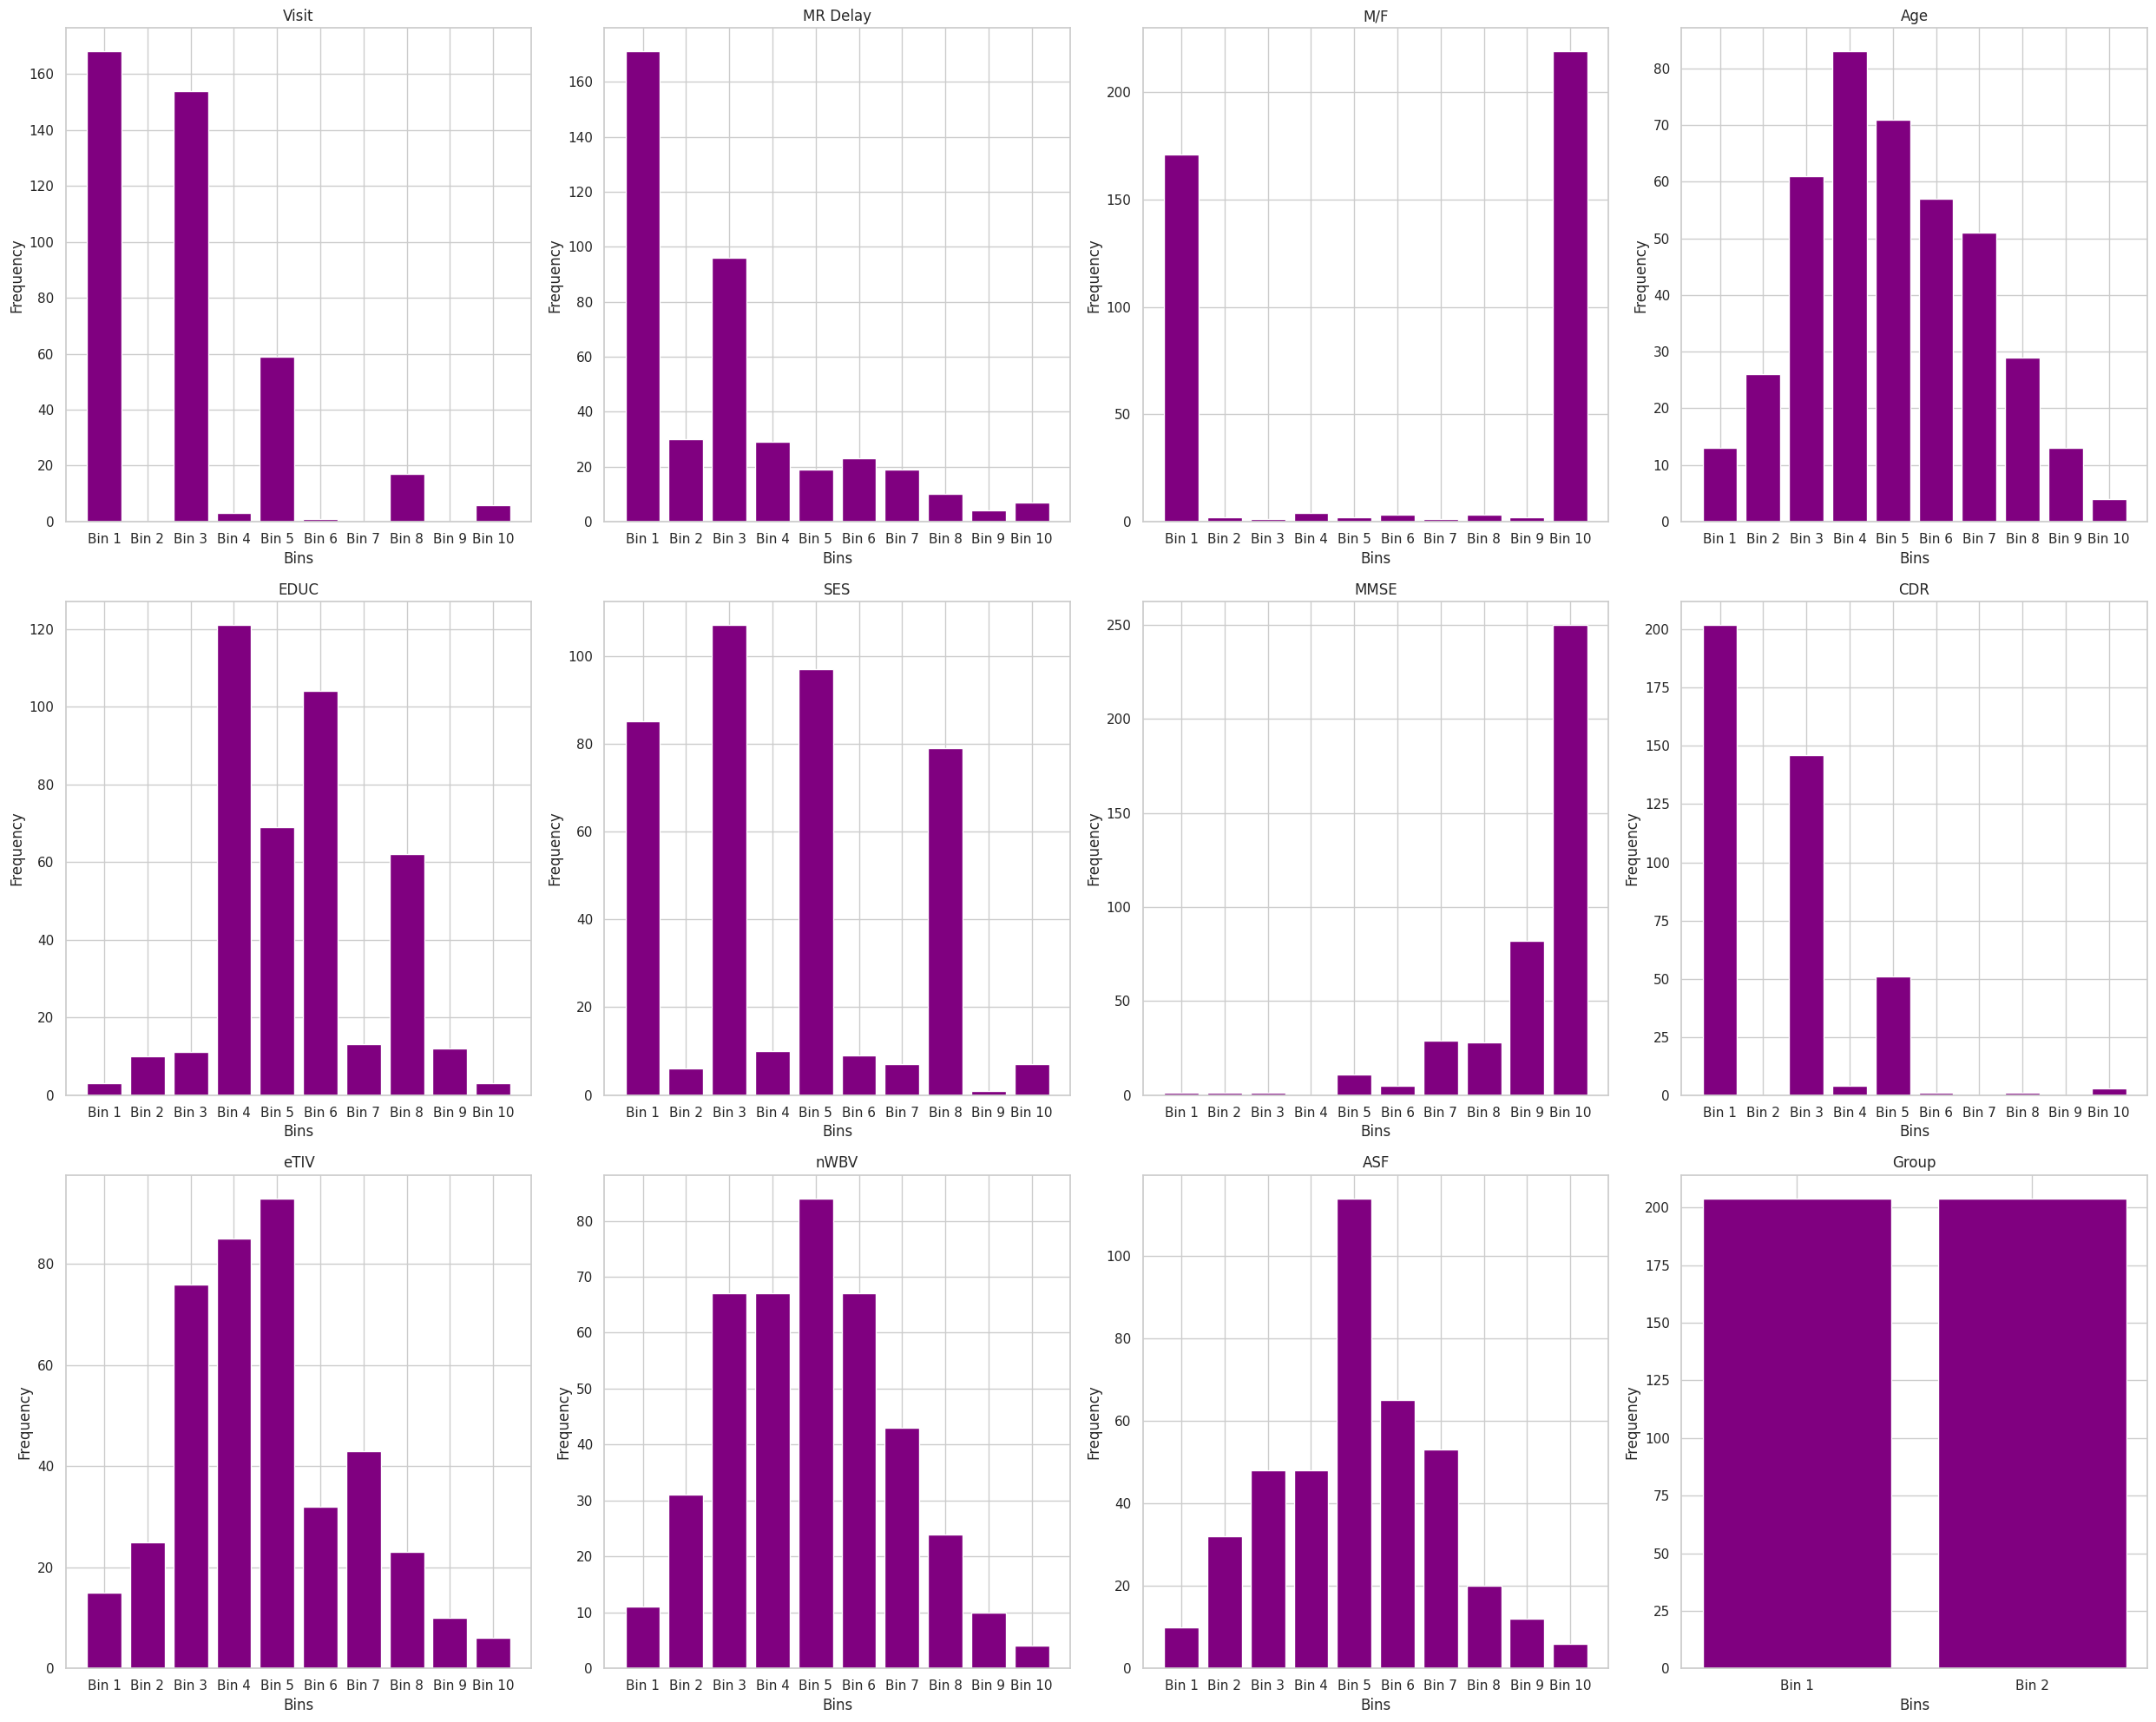

In [8]:
plot_bins_barcharts(dementia_df_sturges)

### Freedman Diaconis Rule Discretisation
---

In [9]:
dementia_df_freedman_diaconis.head()

Visit MR Delay M/F Age EDUC SES MMSE CDR eTIV nWBV ASF Group
0     3        3   3   5    5   3   13   7    6    0   6     1
1     0        0   3   5    8  11   24   0    2    3  10     0
2     0        0   0   4    9   7   23   3    4    7   8     1
3     0        0   3   4    7   3   23   0    6    8   6     0
4     0        0   0   5    5  11   23   0    7    6   6     0

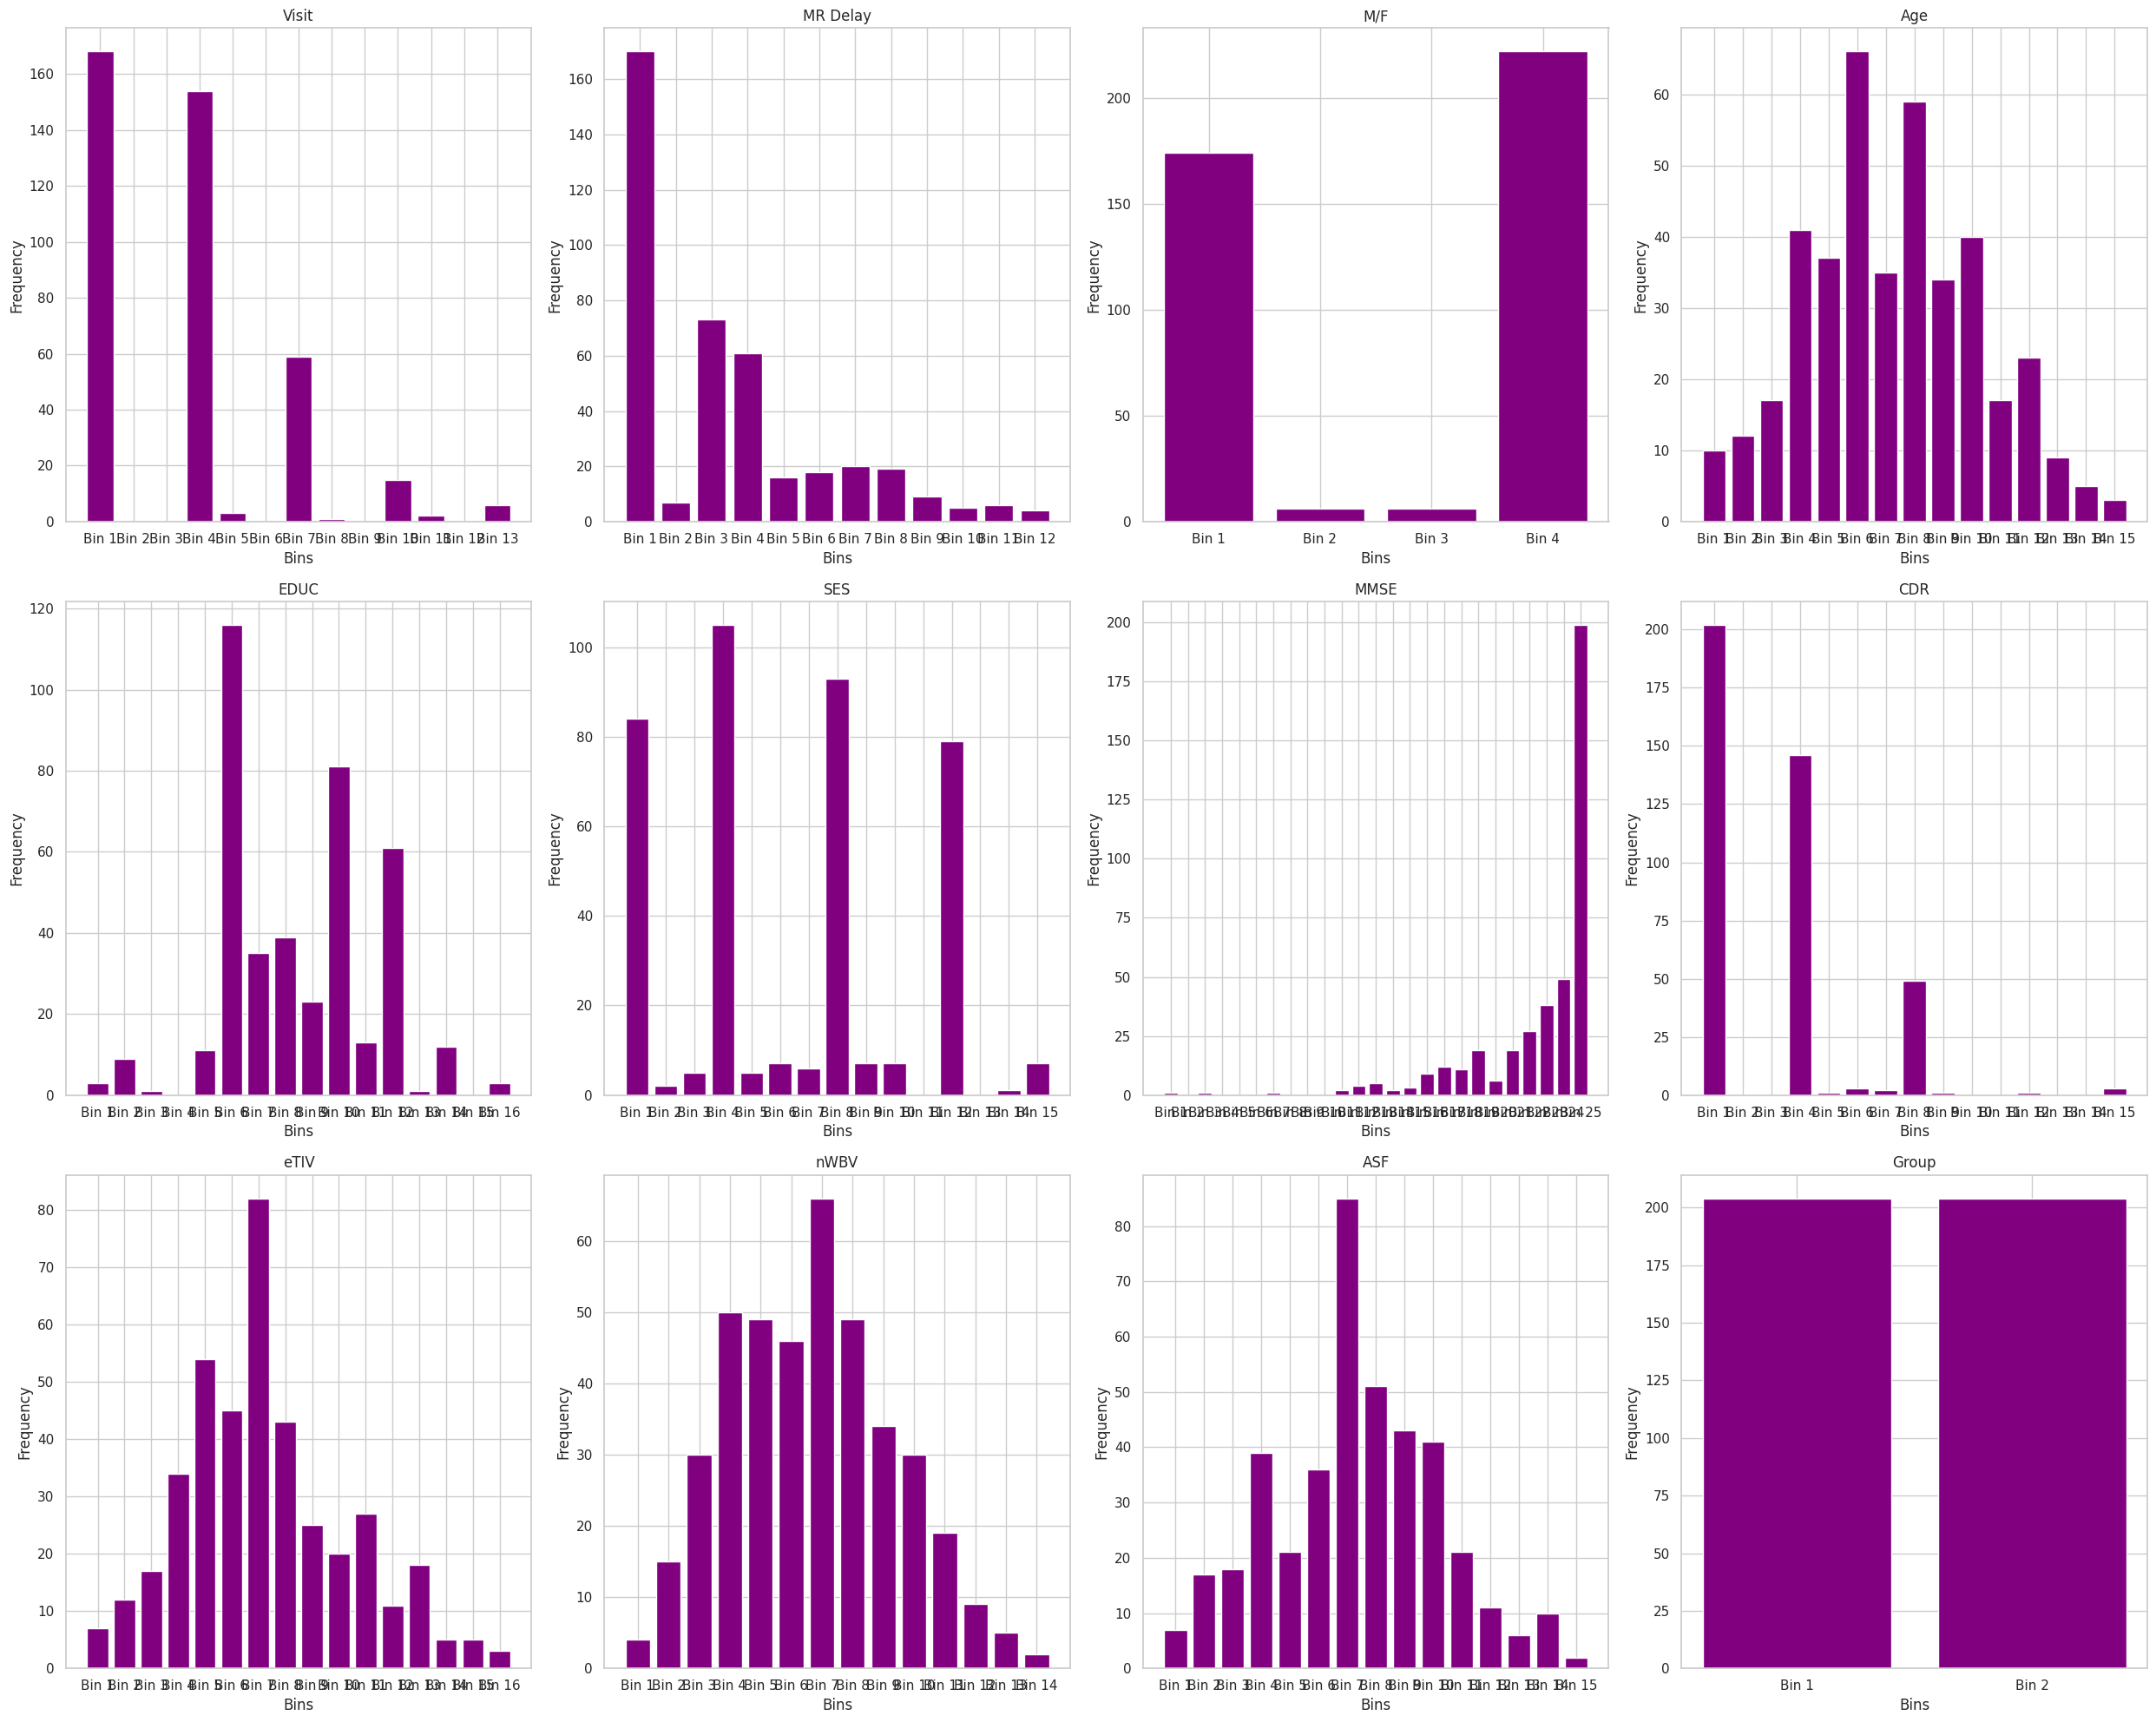

In [10]:
plot_bins_barcharts(dementia_df_freedman_diaconis)

### Comparing Discretisation Methods
---

Visually we can see that the Freedman-Diaconis Rule seemingly performs well compared to the other methods, without much extra computation needed. We can verify this by checking the Mean Squared Error (MSE) in comparison to the original, continuous data.

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mse_5bins = mean_squared_error(dementia_df, dementia_df_5bins)
mse_sturges = mean_squared_error(dementia_df, dementia_df_sturges)
mse_freedman_diaconis = mean_squared_error(dementia_df, dementia_df_freedman_diaconis)

In [13]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

Now we can visualise the MSE scores of each method (the lower the better).

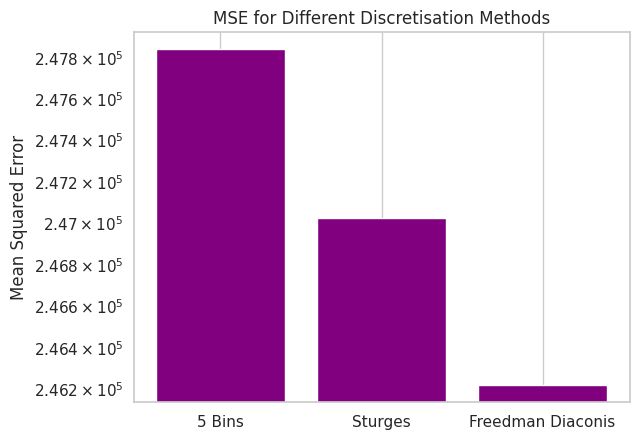

In [14]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

As observed, the Freedman-Diaconis method yields the best performance among the four discretisation methods. However, the significantly high MSE score suggests that discretising the data may not be the most effective approach for this dataset. This indicates that using discrete Bayesian Networks (BNs) could be introducing substantial information loss.

In [15]:
dementia_df = dementia_df_freedman_diaconis.copy()
dementia_df.describe().T

count  unique  top  freq
Visit       408       8    0   168
MR Delay    408      12    0   170
M/F         408       4    3   222
Age         408      15    5    66
EDUC        408      14    5   116
SES         408      13    3   105
MMSE        408      18   24   199
CDR         408       9    0   202
eTIV        408      16    6    82
nWBV        408      14    6    66
ASF         408      15    6    85
Group       408       2    0   204

## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In utils we have defined a function for cross validation, and we can run for each different type of model we want to test to see which one gets the best results.

In [16]:
evaluation = {}

#### Tree-Augmented Naive Bayes
---

In [17]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Group'}

##### Bayes

In [18]:
evaluation_tan_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+----------------------+
| Group    | Group(0)            | Group(1)             |
+----------+---------------------+----------------------+
| eTIV(0)  | 0.04955290611028316 | 0.052290076335877865 |
+----------+---------------------+----------------------+
| eTIV(1)  | 0.05402384500745157 | 0.05381679389312977  |
+----------+---------------------+----------------------+
| eTIV(2)  | 0.05551415797317437 | 0.0583969465648855   |
+----------+---------------------+----------------------+
| eTIV(3)  | 0.06594634873323398 | 0.07213740458015268  |
+----------+---------------------+----------------------+
| eTIV(4)  | 0.0912816691505216  | 0.06603053435114503  |
+--------

100%|██████████| 1/1 [00:00<00:00, 469.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.63it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.38it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 346.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 242.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.59it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.15it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.45it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 467.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 273.80it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.29it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.15it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05037878787878788  | 0.049924924924924924 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.053409090909090906 | 0.05442942942942943  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.054924242424242424 | 0.057432432432432436 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06401515151515151  | 0.06644144144144144  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09128787878787879  | 0.07094594594594594 

100%|██████████| 1/1 [00:00<00:00, 540.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 755.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.68it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 365.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 324.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.92it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05127245508982036  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05726047904191617  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05726047904191617  | 0.05965045592705167  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06773952095808383  | 0.06724924012158055  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09169161676646706  | 0.06724924012158055 

100%|██████████| 1/1 [00:00<00:00, 409.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.70it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 338.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.31it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05015082956259427  | 0.05308734939759036  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.057692307692307696 | 0.05158132530120482  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.059200603318250375 | 0.05760542168674699  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06825037707390648  | 0.06814759036144578  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08484162895927602  | 0.07417168674698796 

100%|██████████| 1/1 [00:00<00:00, 440.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.68it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 175.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.68it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.052370030581039756 | 0.05089153046062407  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05542813455657492  | 0.05237741456166419  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05695718654434251  | 0.056835066864784546 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06613149847094801  | 0.07020802377414562  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08753822629969418  | 0.07169390787518573 

100%|██████████| 1/1 [00:00<00:00, 433.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.60it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 306.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 359.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 679.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.14it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.73it/s]


In [19]:
evaluation['Tree-Augmented Naive Bayes (Bayes)'] = evaluation_tan_bayes

##### Maximum Likelihood

In [20]:
evaluation_tan_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+-----------------------+
| Group    | Group(0)             | Group(1)              |
+----------+----------------------+-----------------------+
| eTIV(0)  | 0.011695906432748537 | 0.01935483870967742   |
+----------+----------------------+-----------------------+
| eTIV(1)  | 0.029239766081871343 | 0.025806451612903226  |
+----------+----------------------+-----------------------+
| eTIV(2)  | 0.03508771929824561  | 0.04516129032258064   |
+----------+----------------------+-----------------------+
| eTIV(3)  | 0.07602339181286549  | 0.1032258064516129    |
+----------+----------------------+-----------------------+
| eTIV(4)  | 0.17543859649122806  | 0.0774193548

100%|██████████| 1/1 [00:00<00:00, 620.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.43it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.33it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 689.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 679.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.35it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.37it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 337.52it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.77it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 340.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.81it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.012048192771084338 |
+----------+----------+----------------------+
| eTIV(1)  | 0.025    | 0.030120481927710843 |
+----------+----------+----------------------+
| eTIV(2)  | 0.03125  | 0.04216867469879518  |
+----------+----------+----------------------+
| eTIV(3)  | 0.06875  | 0.0783132530120482   |
+----------+----------+----------------------+
| eTIV(4)  | 0.18125  | 0.0963855421686747   |
+----------+----------+----------------------+
| eTIV(5)  | 0.075    | 0.12048192771084337  |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 655.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 298.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 339.98it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 341.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 743.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 733.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 334.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.36it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.69it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.017857142857142856 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.041666666666666664 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.041666666666666664 | 0.05063291139240506  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08333333333333333  | 0.08227848101265822  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.17857142857142858  | 0.08227848101265822  |


100%|██████████| 1/1 [00:00<00:00, 672.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 243.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 270.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.42it/s]

[bnlearn]> Remaining columns for inference: 11

100%|██████████| 1/1 [00:00<00:00, 546.20it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 298.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 236.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 762.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 225.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.31it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012269938650306749 | 0.024390243902439025 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.04294478527607362  | 0.018292682926829267 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.049079754601226995 | 0.042682926829268296 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08588957055214724  | 0.08536585365853659  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.15337423312883436  | 0.10975609756097561  |


100%|██████████| 1/1 [00:00<00:00, 566.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.65it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 322.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.68it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.01948051948051948  | 0.017341040462427744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.032467532467532464 | 0.023121387283236993 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.03896103896103896  | 0.04046242774566474  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.07792207792207792  | 0.09248554913294797  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.16883116883116883  | 0.09826589595375723  |


100%|██████████| 1/1 [00:00<00:00, 644.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.66it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 169.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 756.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.51it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.83it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 740.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 736.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 745.92it/s]


In [21]:
evaluation['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = evaluation_tan_ml

#### Hill Climbing
---

In [22]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [23]:
evaluation_hc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+----------------------+
| Group    | Group(0)            | Group(1)             |
+----------+---------------------+----------------------+
| eTIV(0)  | 0.04955290611028316 | 0.052290076335877865 |
+----------+---------------------+----------------------+
| eTIV(1)  | 0.05402384500745157 | 0.05381679389312977  |
+----------+---------------------+----------------------+
| eTIV(2)  | 0.05551415797317437 | 0.0583969465648855   |
+----------+---------------------+----------------------+
| eTIV(3)  | 0.06594634873323398 | 0.07213740458015268  |
+----------+---------------------+----------------------+
| eTIV(4)  | 0.0912816691505216  | 0.06603053435114503  |
+--------

100%|██████████| 1/1 [00:00<00:00, 493.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.59it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 278.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.22it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 516.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.36it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.49it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.69it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.49it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.70it/s]

[bnlearn]> Remaining columns for inference: 11

100%|██████████| 1/1 [00:00<00:00, 667.14it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05037878787878788  | 0.049924924924924924 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.053409090909090906 | 0.05442942942942943  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.054924242424242424 | 0.057432432432432436 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06401515151515151  | 0.06644144144144144  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09128787878787879  | 0.07094594594594594 

100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.02it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 339.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 170.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 700.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.10it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 319.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.55it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05127245508982036  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05726047904191617  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05726047904191617  | 0.05965045592705167  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06773952095808383  | 0.06724924012158055  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09169161676646706  | 0.06724924012158055 

100%|██████████| 1/1 [00:00<00:00, 424.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.17it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 315.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.56it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05015082956259427  | 0.05308734939759036  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.057692307692307696 | 0.05158132530120482  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.059200603318250375 | 0.05760542168674699  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06825037707390648  | 0.06814759036144578  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08484162895927602  | 0.07417168674698796 

100%|██████████| 1/1 [00:00<00:00, 441.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.48it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 740.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.92it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 721.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 733.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.13it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.052370030581039756 | 0.05089153046062407  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05542813455657492  | 0.05237741456166419  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05695718654434251  | 0.056835066864784546 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06613149847094801  | 0.07020802377414562  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08753822629969418  | 0.07169390787518573 

100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.42it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 747.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 313.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.98it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 336.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 310.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.37it/s]


In [24]:
evaluation['BDeu Hill Climbing (Bayes)'] = evaluation_hc_bayes

##### Maximum Likelihood

In [25]:
evaluation_hc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+-----------------------+
| Group    | Group(0)             | Group(1)              |
+----------+----------------------+-----------------------+
| eTIV(0)  | 0.011695906432748537 | 0.01935483870967742   |
+----------+----------------------+-----------------------+
| eTIV(1)  | 0.029239766081871343 | 0.025806451612903226  |
+----------+----------------------+-----------------------+
| eTIV(2)  | 0.03508771929824561  | 0.04516129032258064   |
+----------+----------------------+-----------------------+
| eTIV(3)  | 0.07602339181286549  | 0.1032258064516129    |
+----------+----------------------+-----------------------+
| eTIV(4)  | 0.17543859649122806  | 0.0774193548

100%|██████████| 1/1 [00:00<00:00, 509.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 241.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.84it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.50it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 711.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.78it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.54it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.74it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.40it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 299.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.05it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.012048192771084338 |
+----------+----------+----------------------+
| eTIV(1)  | 0.025    | 0.030120481927710843 |
+----------+----------+----------------------+
| eTIV(2)  | 0.03125  | 0.04216867469879518  |
+----------+----------+----------------------+
| eTIV(3)  | 0.06875  | 0.0783132530120482   |
+----------+----------+----------------------+
| eTIV(4)  | 0.18125  | 0.0963855421686747   |
+----------+----------+----------------------+
| eTIV(5)  | 0.075    | 0.12048192771084337  |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 540.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.23it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.10it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 555.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 343.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.78it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 733.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.86it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.017857142857142856 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.041666666666666664 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.041666666666666664 | 0.05063291139240506  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08333333333333333  | 0.08227848101265822  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.17857142857142858  | 0.08227848101265822  |


100%|██████████| 1/1 [00:00<00:00, 464.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 342.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.95it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 679.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 718.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 342.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 670.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.02it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 569.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.77it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012269938650306749 | 0.024390243902439025 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.04294478527607362  | 0.018292682926829267 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.049079754601226995 | 0.042682926829268296 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08588957055214724  | 0.08536585365853659  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.15337423312883436  | 0.10975609756097561  |


100%|██████████| 1/1 [00:00<00:00, 613.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 752.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 336.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 259.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.22it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 756.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 346.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 707.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 749.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.15it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.01948051948051948  | 0.017341040462427744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.032467532467532464 | 0.023121387283236993 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.03896103896103896  | 0.04046242774566474  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.07792207792207792  | 0.09248554913294797  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.16883116883116883  | 0.09826589595375723  |


100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.15it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 759.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.23it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 602.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.72it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 560.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.52it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.75it/s]


In [26]:
evaluation['BDeu Hill Climbing (Maximum Likelihood)'] = evaluation_hc_ml

#### PC Algorithm
---

In [27]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [28]:
evaluation_pc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+----------------------+
| Group    | Group(0)            | Group(1)             |
+----------+---------------------+----------------------+
| eTIV(0)  | 0.04955290611028316 | 0.052290076335877865 |
+----------+---------------------+----------------------+
| eTIV(1)  | 0.05402384500745157 | 0.05381679389312977  |
+----------+---------------------+----------------------+
| eTIV(2)  | 0.05551415797317437 | 0.0583969465648855   |
+----------+---------------------+----------------------+
| eTIV(3)  | 0.06594634873323398 | 0.07213740458015268  |
+----------+---------------------+----------------------+
| eTIV(4)  | 0.0912816691505216  | 0.06603053435114503  |
+--------

100%|██████████| 1/1 [00:00<00:00, 489.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.91it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.09it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 315.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.32it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 332.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 339.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.51it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.97it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.59it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.09it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05037878787878788  | 0.049924924924924924 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.053409090909090906 | 0.05442942942942943  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.054924242424242424 | 0.057432432432432436 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06401515151515151  | 0.06644144144144144  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09128787878787879  | 0.07094594594594594 

100%|██████████| 1/1 [00:00<00:00, 501.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.51it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 340.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 289.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.33it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.69it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05127245508982036  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05726047904191617  | 0.05357142857142857  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05726047904191617  | 0.05965045592705167  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06773952095808383  | 0.06724924012158055  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.09169161676646706  | 0.06724924012158055 

100%|██████████| 1/1 [00:00<00:00, 491.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.64it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 683.33it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 297.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 761.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.41it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05015082956259427  | 0.05308734939759036  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.057692307692307696 | 0.05158132530120482  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.059200603318250375 | 0.05760542168674699  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06825037707390648  | 0.06814759036144578  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08484162895927602  | 0.07417168674698796 

100%|██████████| 1/1 [00:00<00:00, 505.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.47it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 735.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 758.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.77it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.052370030581039756 | 0.05089153046062407  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.05542813455657492  | 0.05237741456166419  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05695718654434251  | 0.056835066864784546 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.06613149847094801  | 0.07020802377414562  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08753822629969418  | 0.07169390787518573 

100%|██████████| 1/1 [00:00<00:00, 515.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 334.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.19it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 736.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 730.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 744.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 744.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 742.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 728.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.80it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.88it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.22it/s]


In [29]:
evaluation['PC Algorithm (Bayes)'] = evaluation_pc_bayes

##### Maximum Likelihood

In [30]:
evaluation_pc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+-----------------------+
| Group    | Group(0)             | Group(1)              |
+----------+----------------------+-----------------------+
| eTIV(0)  | 0.011695906432748537 | 0.01935483870967742   |
+----------+----------------------+-----------------------+
| eTIV(1)  | 0.029239766081871343 | 0.025806451612903226  |
+----------+----------------------+-----------------------+
| eTIV(2)  | 0.03508771929824561  | 0.04516129032258064   |
+----------+----------------------+-----------------------+
| eTIV(3)  | 0.07602339181286549  | 0.1032258064516129    |
+----------+----------------------+-----------------------+
| eTIV(4)  | 0.17543859649122806  | 0.0774193548

100%|██████████| 1/1 [00:00<00:00, 546.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.25it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 8 in fold 1: KeyError - 10
Row causing error:    Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
8     10        10    0   10     8    4    23    3     8     3    4      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.37it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 18 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
18      3         2    0    4     8    5    18    5     8     4    5      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 41 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
41      3         2    1    5     6    8    16    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 52 in fold 1: KeyError - 8
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
52      3         3    0    9     6    9    15    8     6     1    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.56it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 56 in fold 1: KeyError - 10
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
56     10        11    0   11     6    9    21    3     7     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.29it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 61 in fold 1: KeyError - 5
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
61      0         0    0    7     6    7    20    5     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 770.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 753.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 744.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.77it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.012048192771084338 |
+----------+----------+----------------------+
| eTIV(1)  | 0.025    | 0.030120481927710843 |
+----------+----------+----------------------+
| eTIV(2)  | 0.03125  | 0.04216867469879518  |
+----------+----------+----------------------+
| eTIV(3)  | 0.06875  | 0.0783132530120482   |
+----------+----------+----------------------+
| eTIV(4)  | 0.18125  | 0.0963855421686747   |
+----------+----------+----------------------+
| eTIV(5)  | 0.075    | 0.12048192771084337  |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 667.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 742.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.78it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 95 in fold 2: KeyError - 6
Row causing error:     Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
95      9         5    0    4    10    0     6    6    11     3    2      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 750.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 756.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.53it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 568.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 775.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.90it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 2: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
150      0         0    3    5     2   13    20    3     0     7   13      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 752.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.35it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.017857142857142856 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.041666666666666664 | 0.02531645569620253  |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.041666666666666664 | 0.05063291139240506  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08333333333333333  | 0.08227848101265822  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.17857142857142858  | 0.08227848101265822  |


100%|██████████| 1/1 [00:00<00:00, 478.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 759.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 735.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 747.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.80it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Error for row 189 in fold 3: KeyError - 4
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
189      3         3    3    7     5    7    17    4     6     6    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'nWBV', 'M/F', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 692.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.65it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 740.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 770.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 751.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 730.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 728.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.17it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012269938650306749 | 0.024390243902439025 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.04294478527607362  | 0.018292682926829267 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.049079754601226995 | 0.042682926829268296 |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08588957055214724  | 0.08536585365853659  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.15337423312883436  | 0.10975609756097561  |


100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 756.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 751.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 775.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.67it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 266 in fold 4: KeyError - 7
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
266      7         9    1   11     6    7    21    3     6     4    6      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 726.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 749.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 746.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 707.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 730.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 760.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 753.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 724.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 787.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 739.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 651.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.51it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.01948051948051948  | 0.017341040462427744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.032467532467532464 | 0.023121387283236993 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.03896103896103896  | 0.04046242774566474  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.07792207792207792  | 0.09248554913294797  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.16883116883116883  | 0.09826589595375723  |


100%|██████████| 1/1 [00:00<00:00, 569.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.42it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 331 in fold 5: KeyError - 0
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
331     12         5    0    3     9    0     0    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 751.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 757.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 754.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 793.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 749.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 759.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 754.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 706.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 672.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 736.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 707.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.88it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 379 in fold 5: KeyError - 2
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
379      9         4    0    3     9    0     2    7    10     2    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.20it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 390 in fold 5: KeyError - 12
Row causing error:      Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF  Group
390      3         2    0    7    12    0    21   11    10     7    3      1
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'MMSE', 'M/F', 'nWBV', 'SES', 'CDR', 'Age', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.97it/s]


In [31]:
evaluation['PC Algorithm (Maximum Likelihood)'] = evaluation_pc_ml

### Evaluation
---

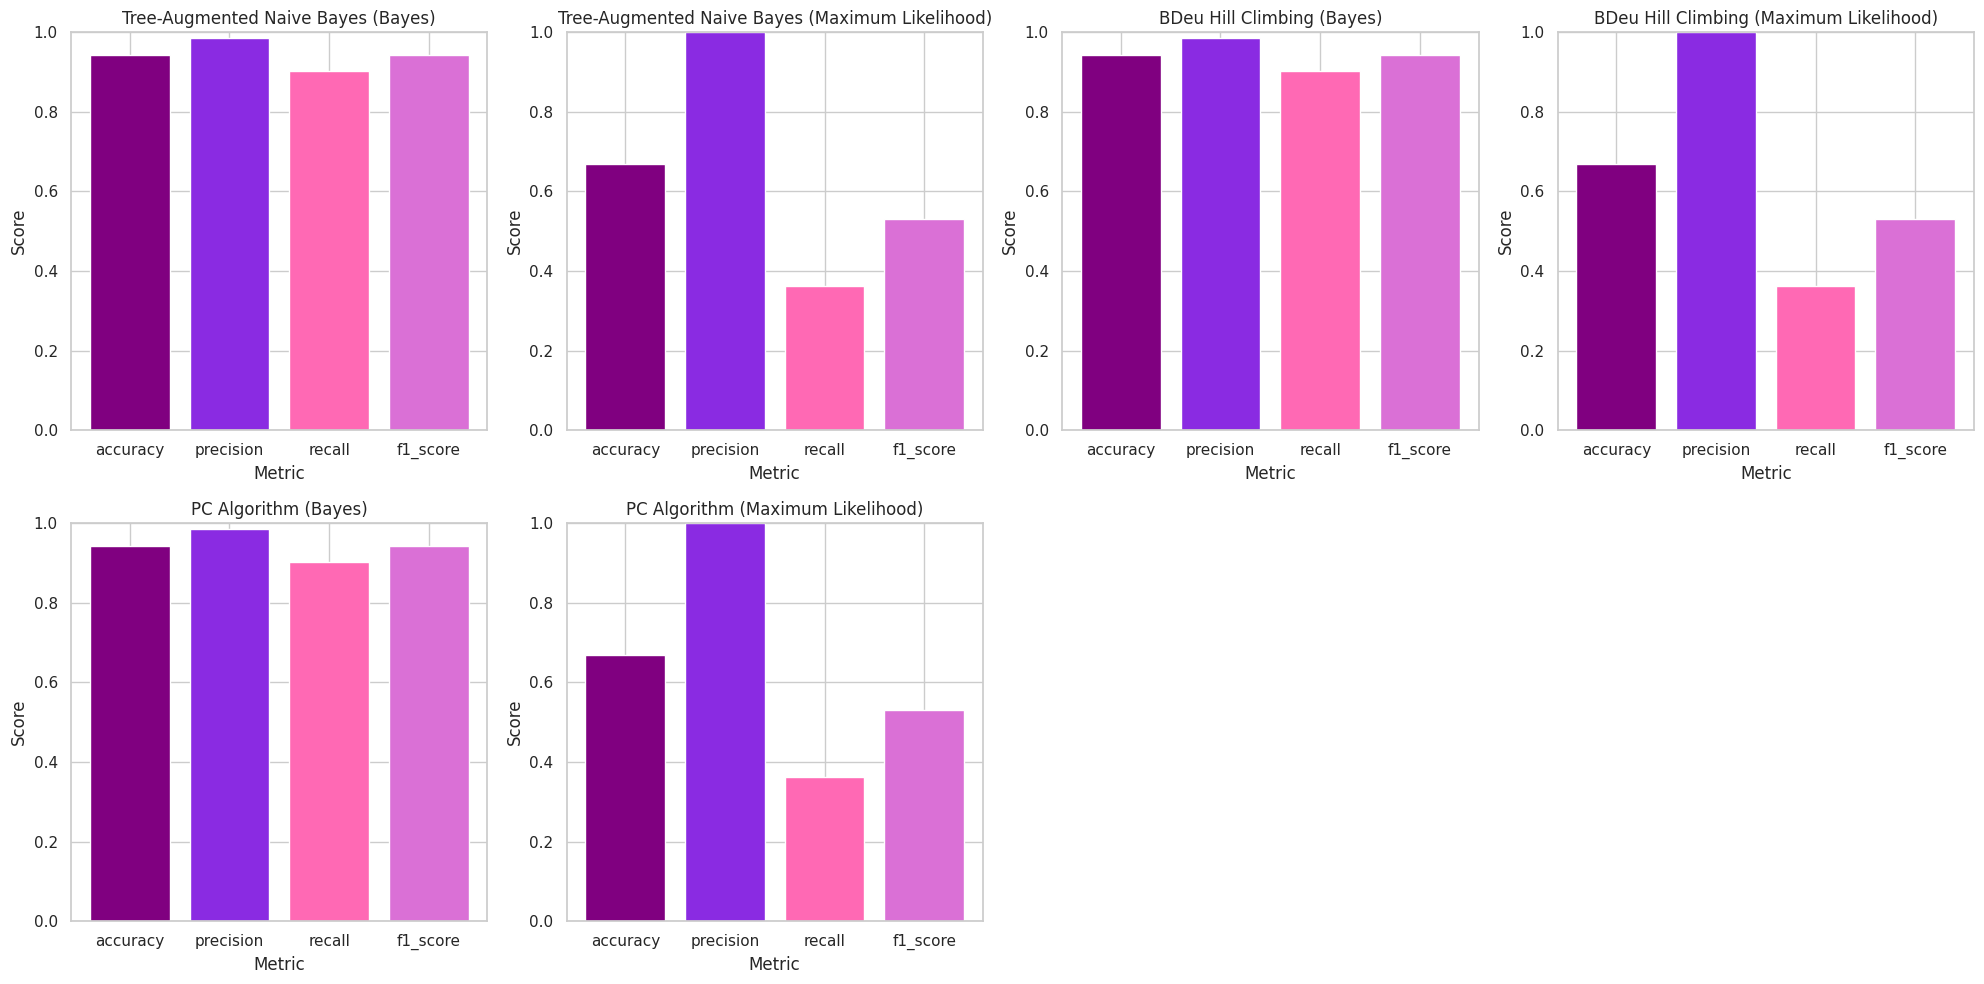

In [32]:
plot_metrics_from_evaluation(evaluation)

In [33]:
display_evaluation_results(evaluation)


Tree-Augmented Naive Bayes (Bayes):
  Metrics:
    Classification:
      Accuracy: 94.24%
      Precision: 98.47%
      Recall: 90.35%
      F1_score: 94.22%
    Roc_auc: 0.9443587278881223
    Brier_score: 0.05755558199680625
    Log_loss: 2.0745134481017957
  Time Taken: 41.55 seconds
  Confusion Matrix: [201   3]
                    [ 17 174]

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Metrics:
    Classification:
      Accuracy: 66.84%
      Precision: 100.00%
      Recall: 36.15%
      F1_score: 53.07%
    Roc_auc: 0.6807322746687318
    Brier_score: 0.3315589251265152
    Log_loss: 11.950594975328361
  Time Taken: 5.60 seconds
  Confusion Matrix: [204   0]
                    [120  71]

BDeu Hill Climbing (Bayes):
  Metrics:
    Classification:
      Accuracy: 94.24%
      Precision: 98.47%
      Recall: 90.35%
      F1_score: 94.22%
    Roc_auc: 0.9443587278881223
    Brier_score: 0.05755558199680625
    Log_loss: 2.0745134481017957
  Time Taken: 38.72 seconds
  Confusi

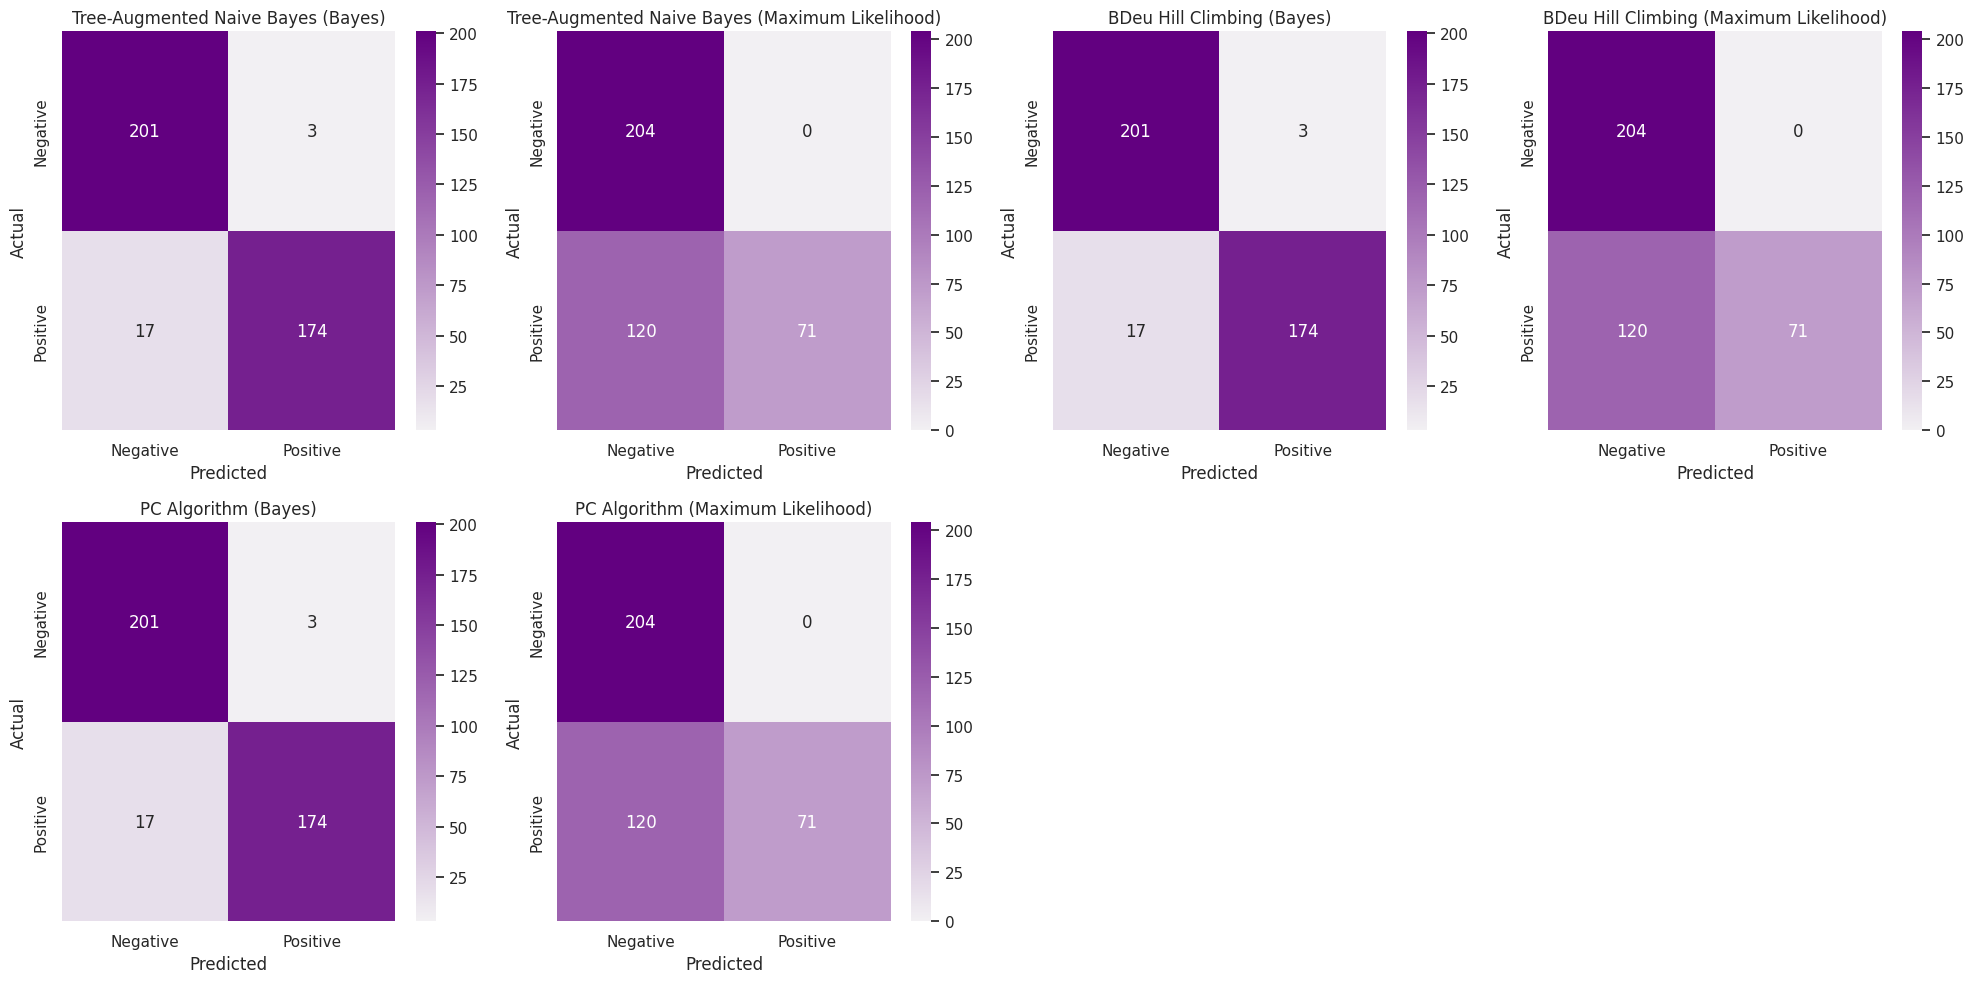

In [34]:
plot_confusion_matrices_from_evaluation(evaluation, cmap=gradient_palette)

# Parkinson's Disease
---

In [35]:
parkinsons_df = pd.read_csv('data/parkinsons_data_processed.csv')

## Discretising the Data
---

In [36]:
parkinsons_df_5bins = discretise(parkinsons_df.copy(), nbins=5)
parkinsons_df_sturges = discretise(parkinsons_df.copy(), method='sturges')
parkinsons_df_freedman_diaconis = discretise(parkinsons_df.copy(), method='freedman-diaconis')

### 5 Bin
---

In [37]:
parkinsons_df_5bins.head()

MDVP:Fo(Hz) MDVP:Fhi(Hz) MDVP:Flo(Hz) MDVP:Jitter(%) MDVP:Jitter(Abs)  \
0           0            4            0              0                0   
1           0            0            0              0                1   
2           1            1            0              0                0   
3           1            0            0              1                1   
4           0            0            0              0                0   

  MDVP:RAP MDVP:PPQ Jitter:DDP MDVP:Shimmer MDVP:Shimmer(dB)  ... Shimmer:DDA  \
0        0        0          0            0                0  ...           0   
1        0        0          0            1                0  ...           1   
2        0        0          0            1                1  ...           2   
3        1        0          1            0                0  ...           1   
4        0        0          0            0                0  ...           0   

  NHR HNR RPDE DFA spread1 spread2 D2 PPE Status  
0   0   3    3   1       1       1  1   0      0  
1   0   2    4   4       2       2  1   2      1  
2   0   2    3   3       2       1  1   1      1  
3   0   2    4   1       2       3  3   2      1  
4   0   3    2   2       2       2  2   1      1  

[5 rows x 23 columns]

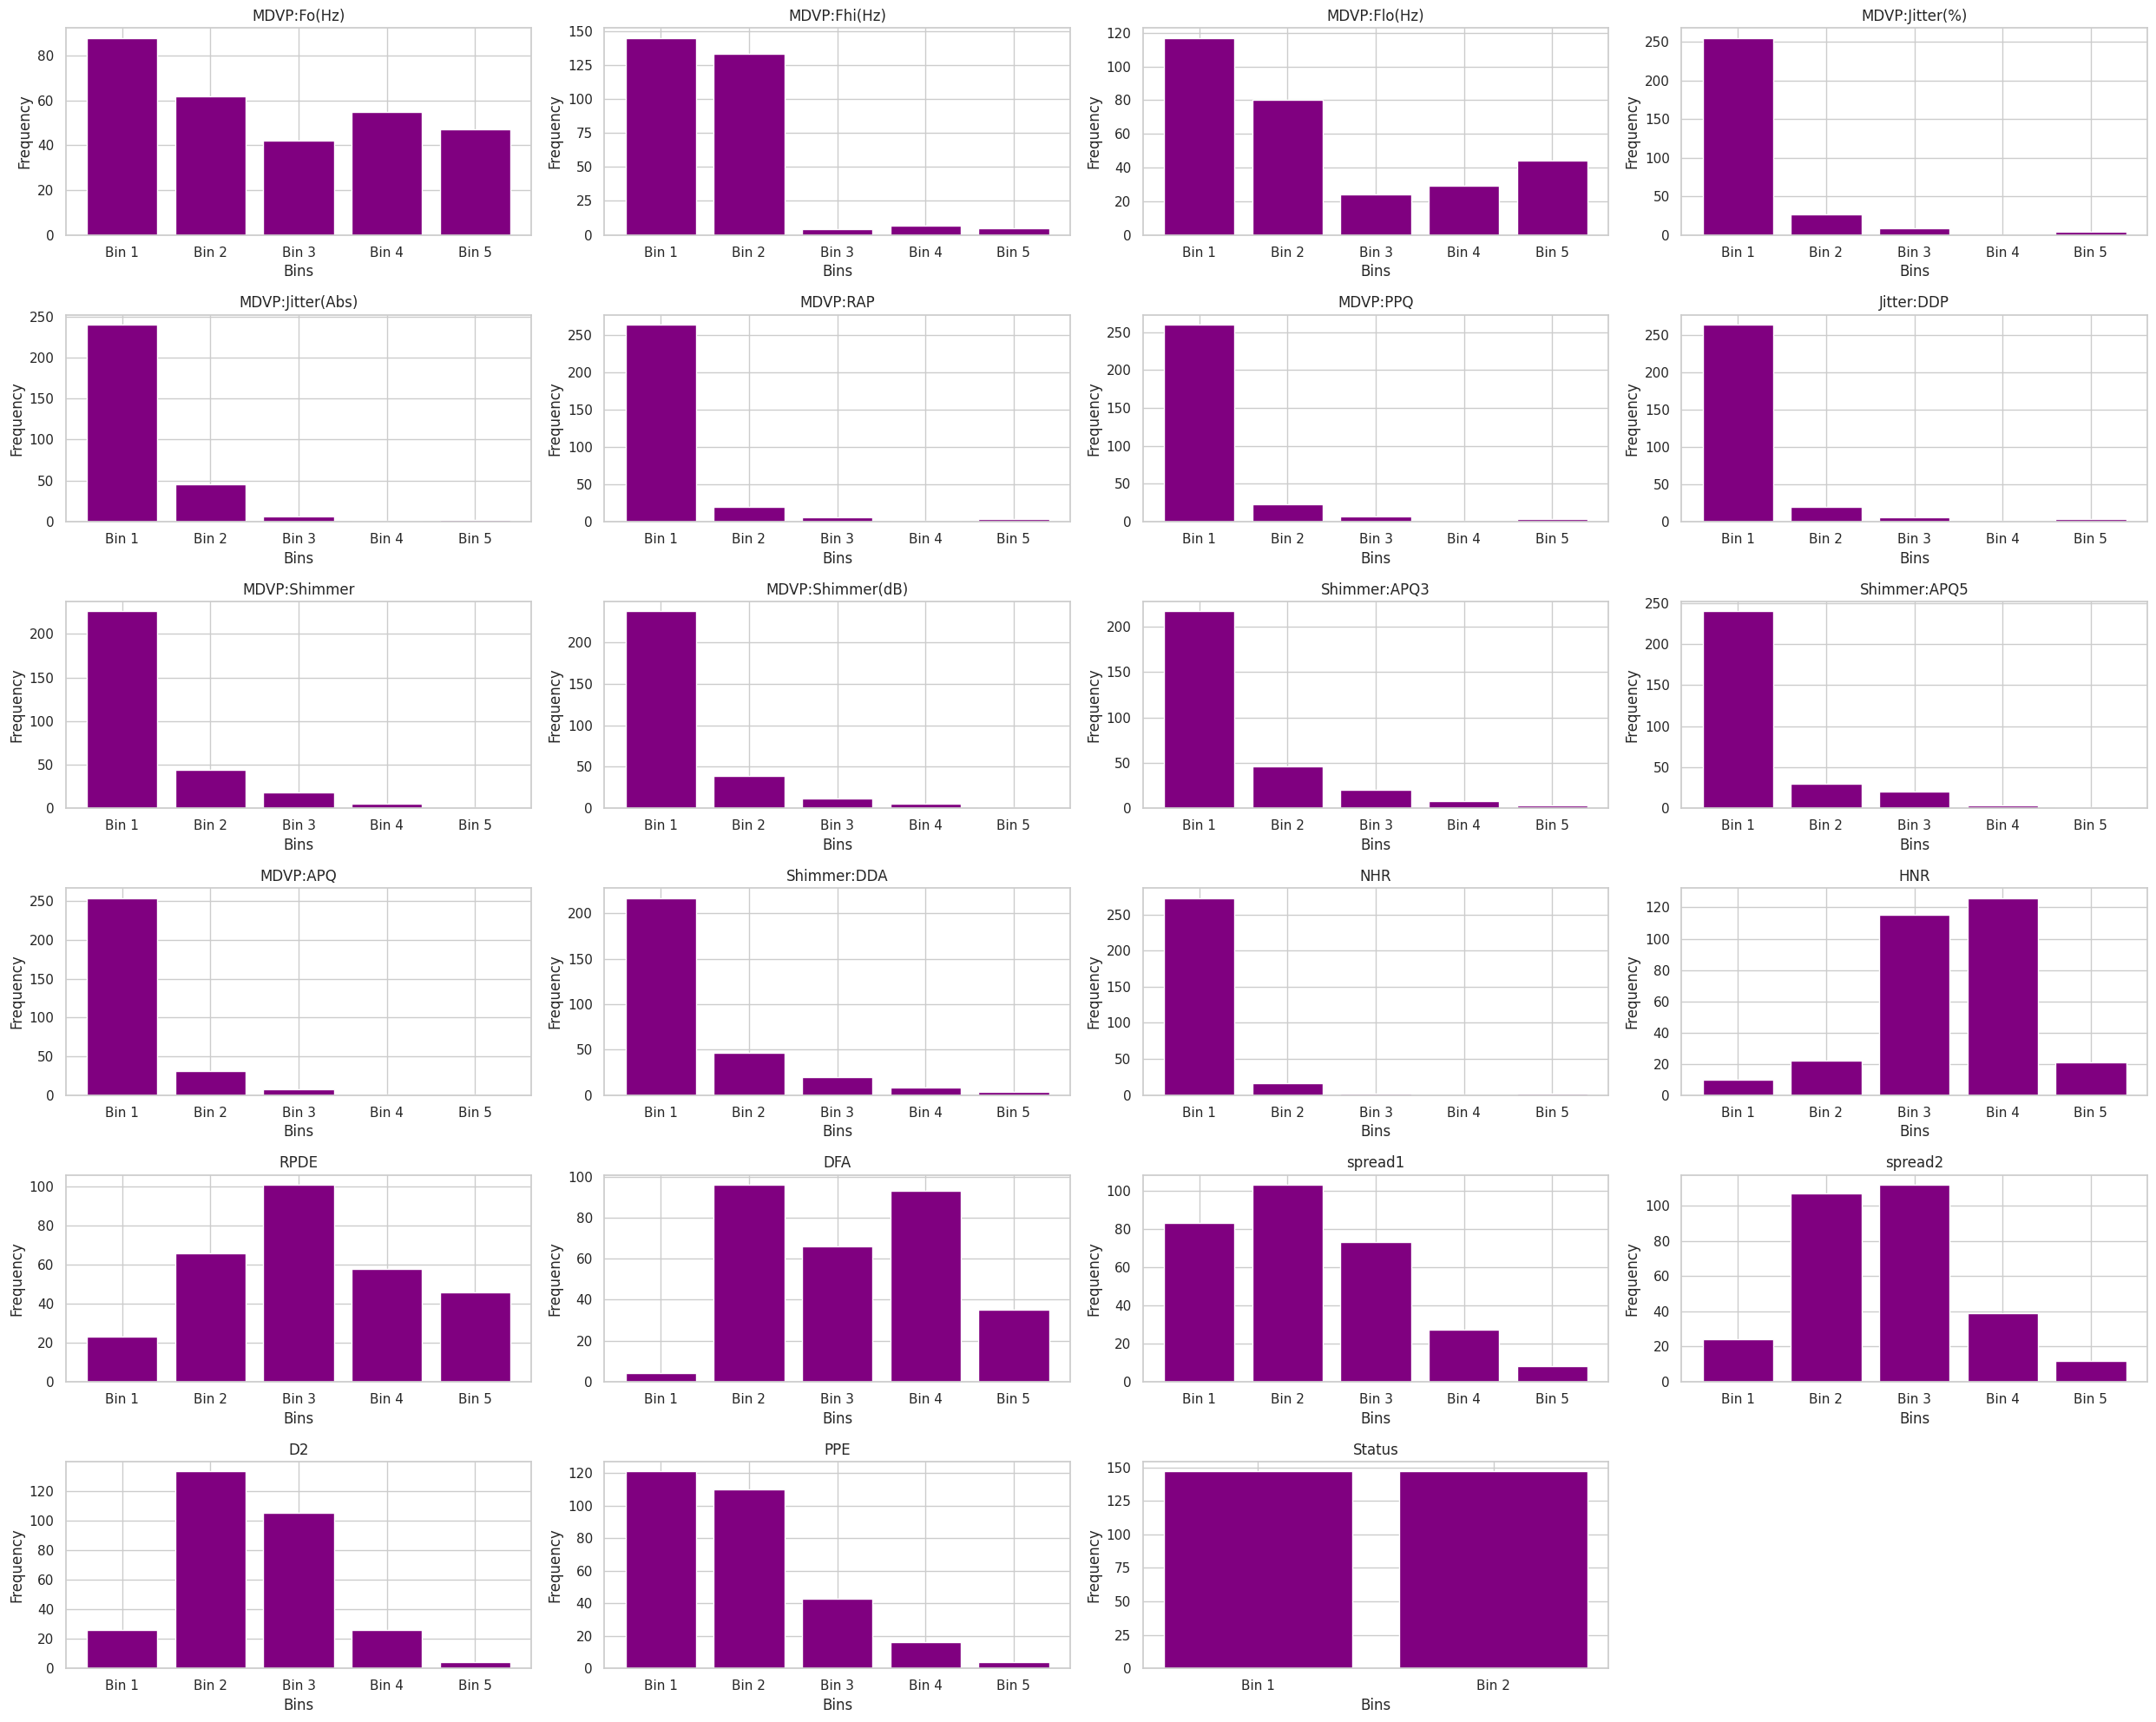

In [38]:
plot_bins_barcharts(parkinsons_df_5bins)

### Sturges
---

In [39]:
parkinsons_df_sturges.head()

MDVP:Fo(Hz) MDVP:Fhi(Hz) MDVP:Flo(Hz) MDVP:Jitter(%) MDVP:Jitter(Abs)  \
0           1            9            1              1                1   
1           0            0            1              1                2   
2           2            2            1              1                1   
3           2            1            1              2                2   
4           1            0            1              0                0   

  MDVP:RAP MDVP:PPQ Jitter:DDP MDVP:Shimmer MDVP:Shimmer(dB)  ... Shimmer:DDA  \
0        0        0          0            0                0  ...           0   
1        1        1          1            2                1  ...           2   
2        1        1          1            3                2  ...           4   
3        2        1          2            1                1  ...           2   
4        0        0          0            0                0  ...           0   

  NHR HNR RPDE DFA spread1 spread2 D2 PPE Status  
0   0   6    7   3       2       3  3   1      0  
1   0   5    9   8       5       5  2   4      1  
2   0   4    6   6       4       3  2   3      1  
3   1   5    8   2       5       6  6   4      1  
4   0   6    5   5       4       5  4   3      1  

[5 rows x 23 columns]

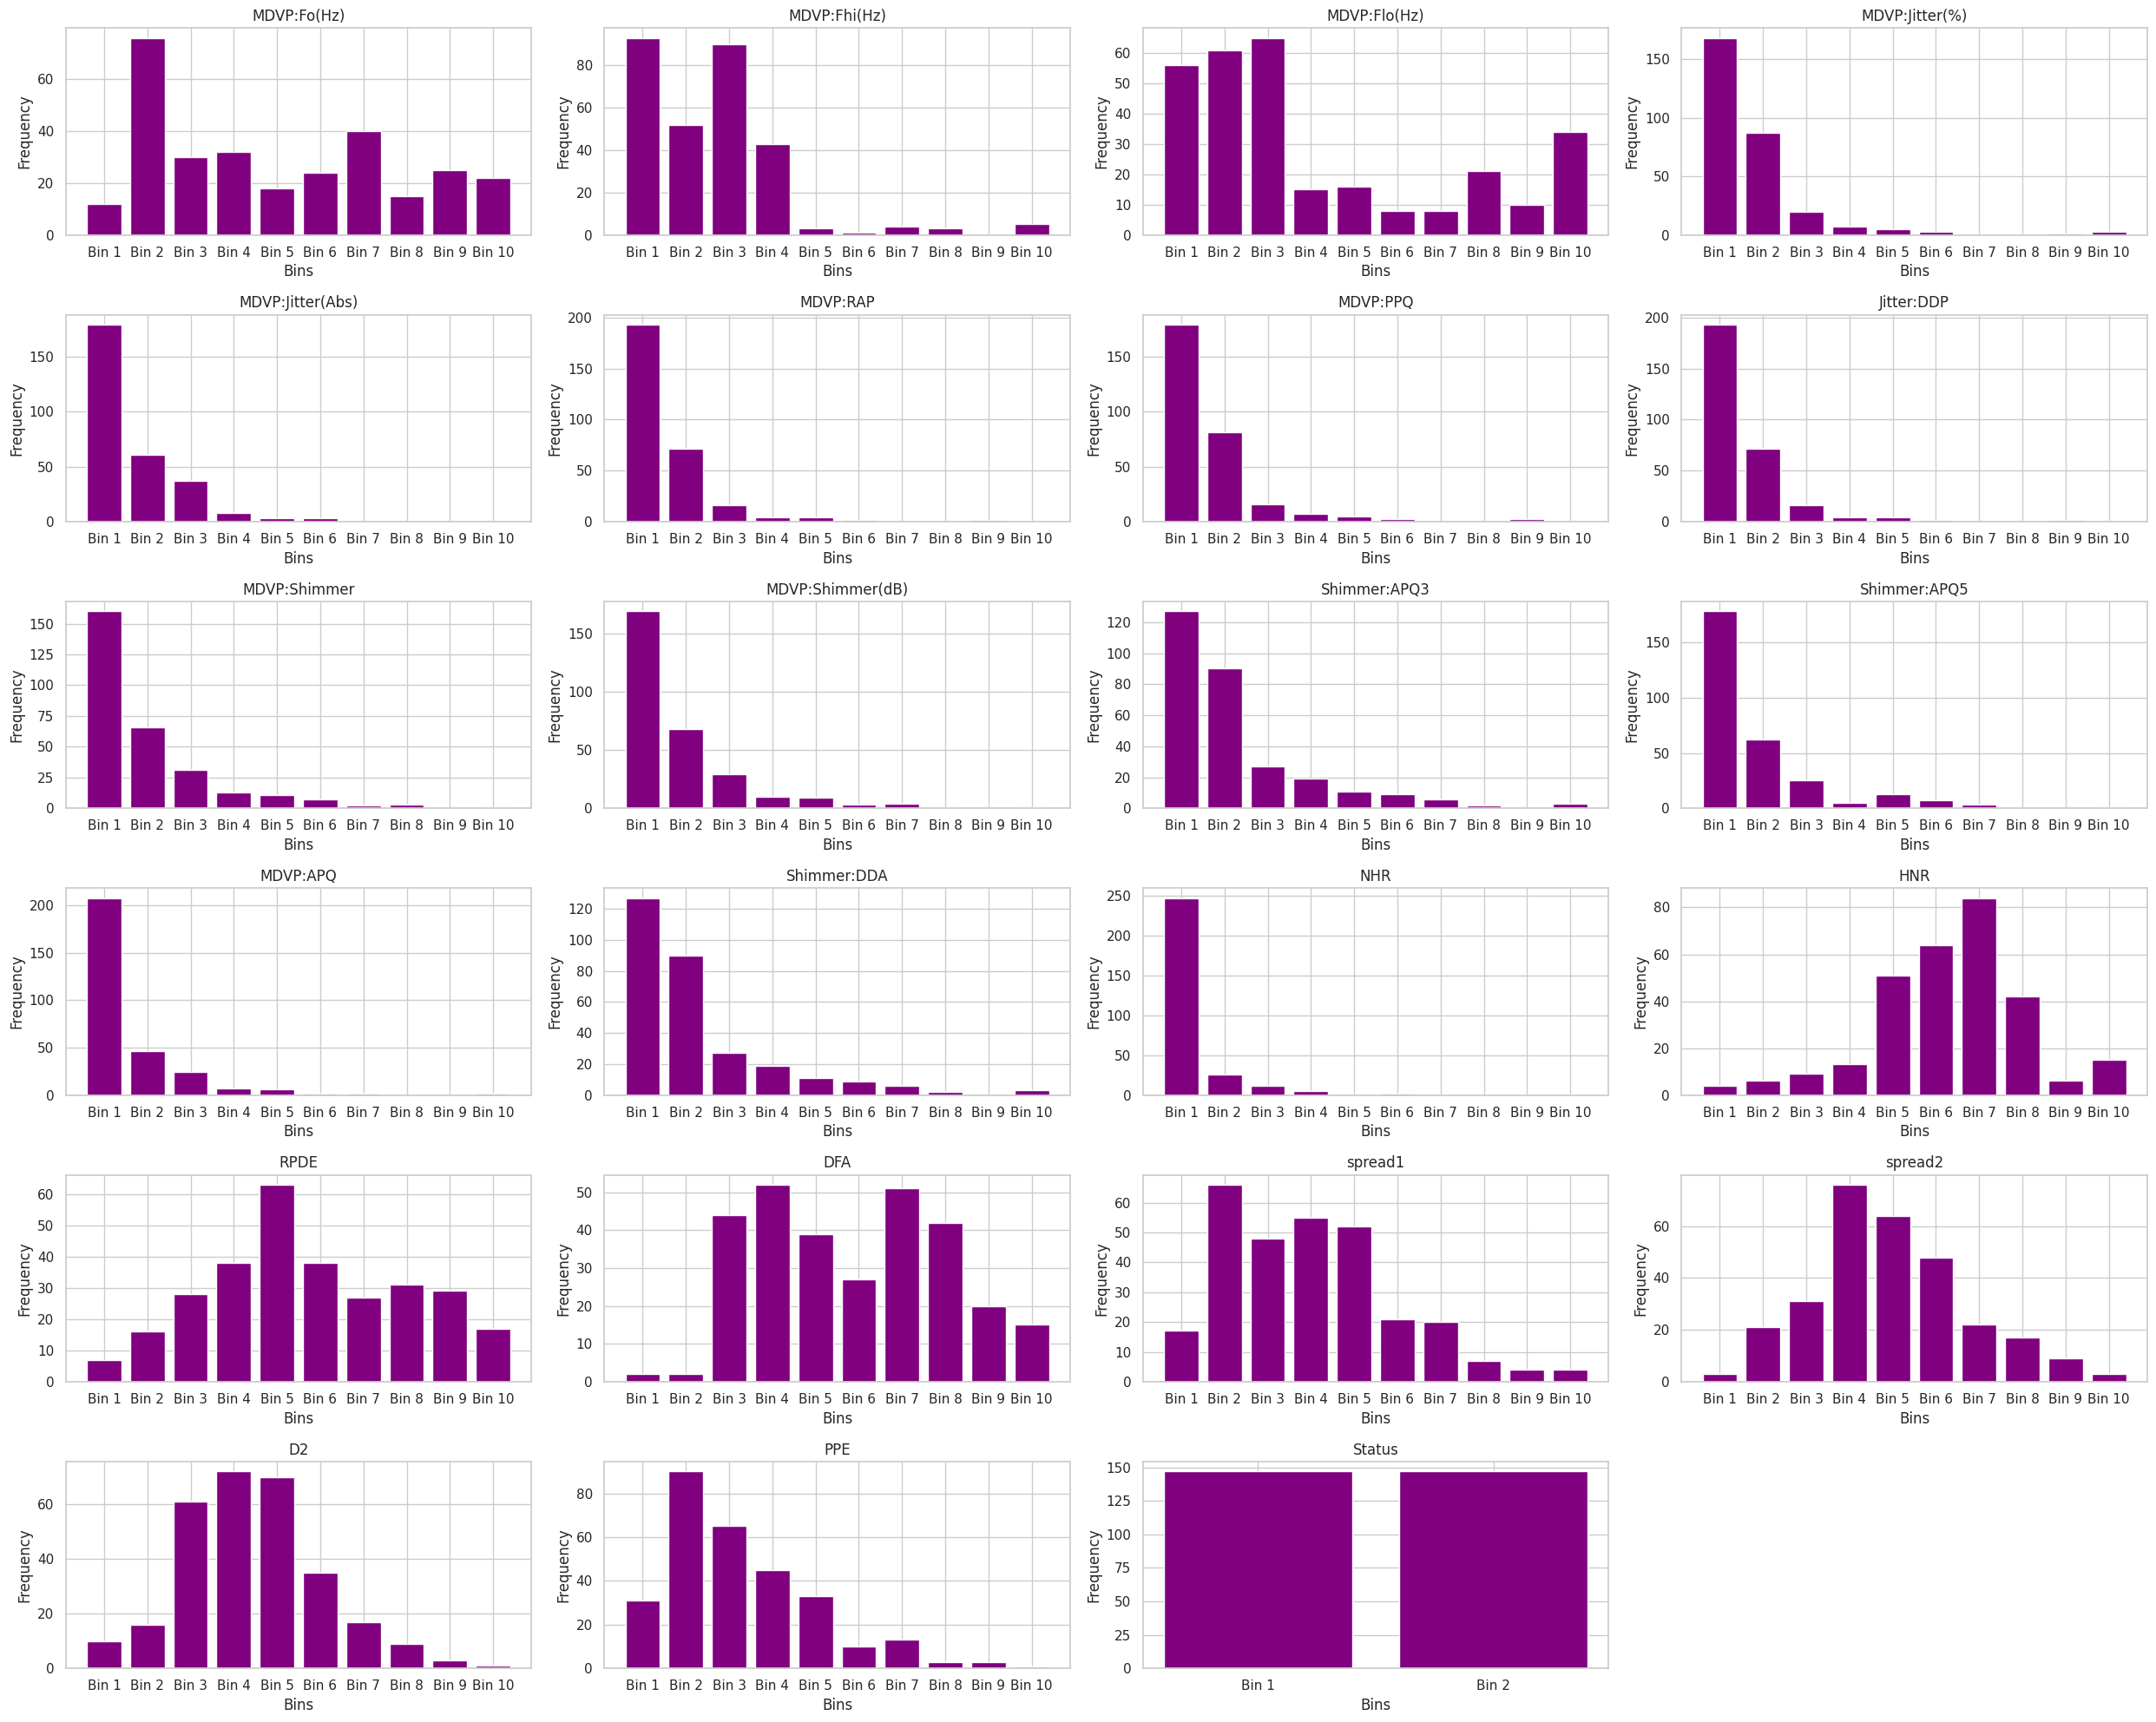

In [40]:
plot_bins_barcharts(parkinsons_df_sturges)

### Freedman Diaconis
---

In [41]:
parkinsons_df_freedman_diaconis.head()

MDVP:Fo(Hz) MDVP:Fhi(Hz) MDVP:Flo(Hz) MDVP:Jitter(%) MDVP:Jitter(Abs)  \
0           1           15            0              3                3   
1           0            0            1              4                6   
2           2            3            0              5                4   
3           1            1            1              8                8   
4           1            0            0              1                2   

  MDVP:RAP MDVP:PPQ Jitter:DDP MDVP:Shimmer MDVP:Shimmer(dB)  ... Shimmer:DDA  \
0        3        3          3            1                1  ...           1   
1        4        4          4            5                4  ...           5   
2        6        5          6            8                9  ...           9   
3        9        6          9            4                4  ...           4   
4        1        1          1            0                0  ...           0   

  NHR HNR RPDE DFA spread1 spread2  D2 PPE Status  
0   2  10    7   3       3       4   5   2      0  
1   2   9    9   7       6       8   4   6      1  
2   4   6    6   5       5       5   5   5      1  
3   8   9    8   1       6       9  11   5      1  
4   1  10    5   5       5       8   8   5      1  

[5 rows x 23 columns]

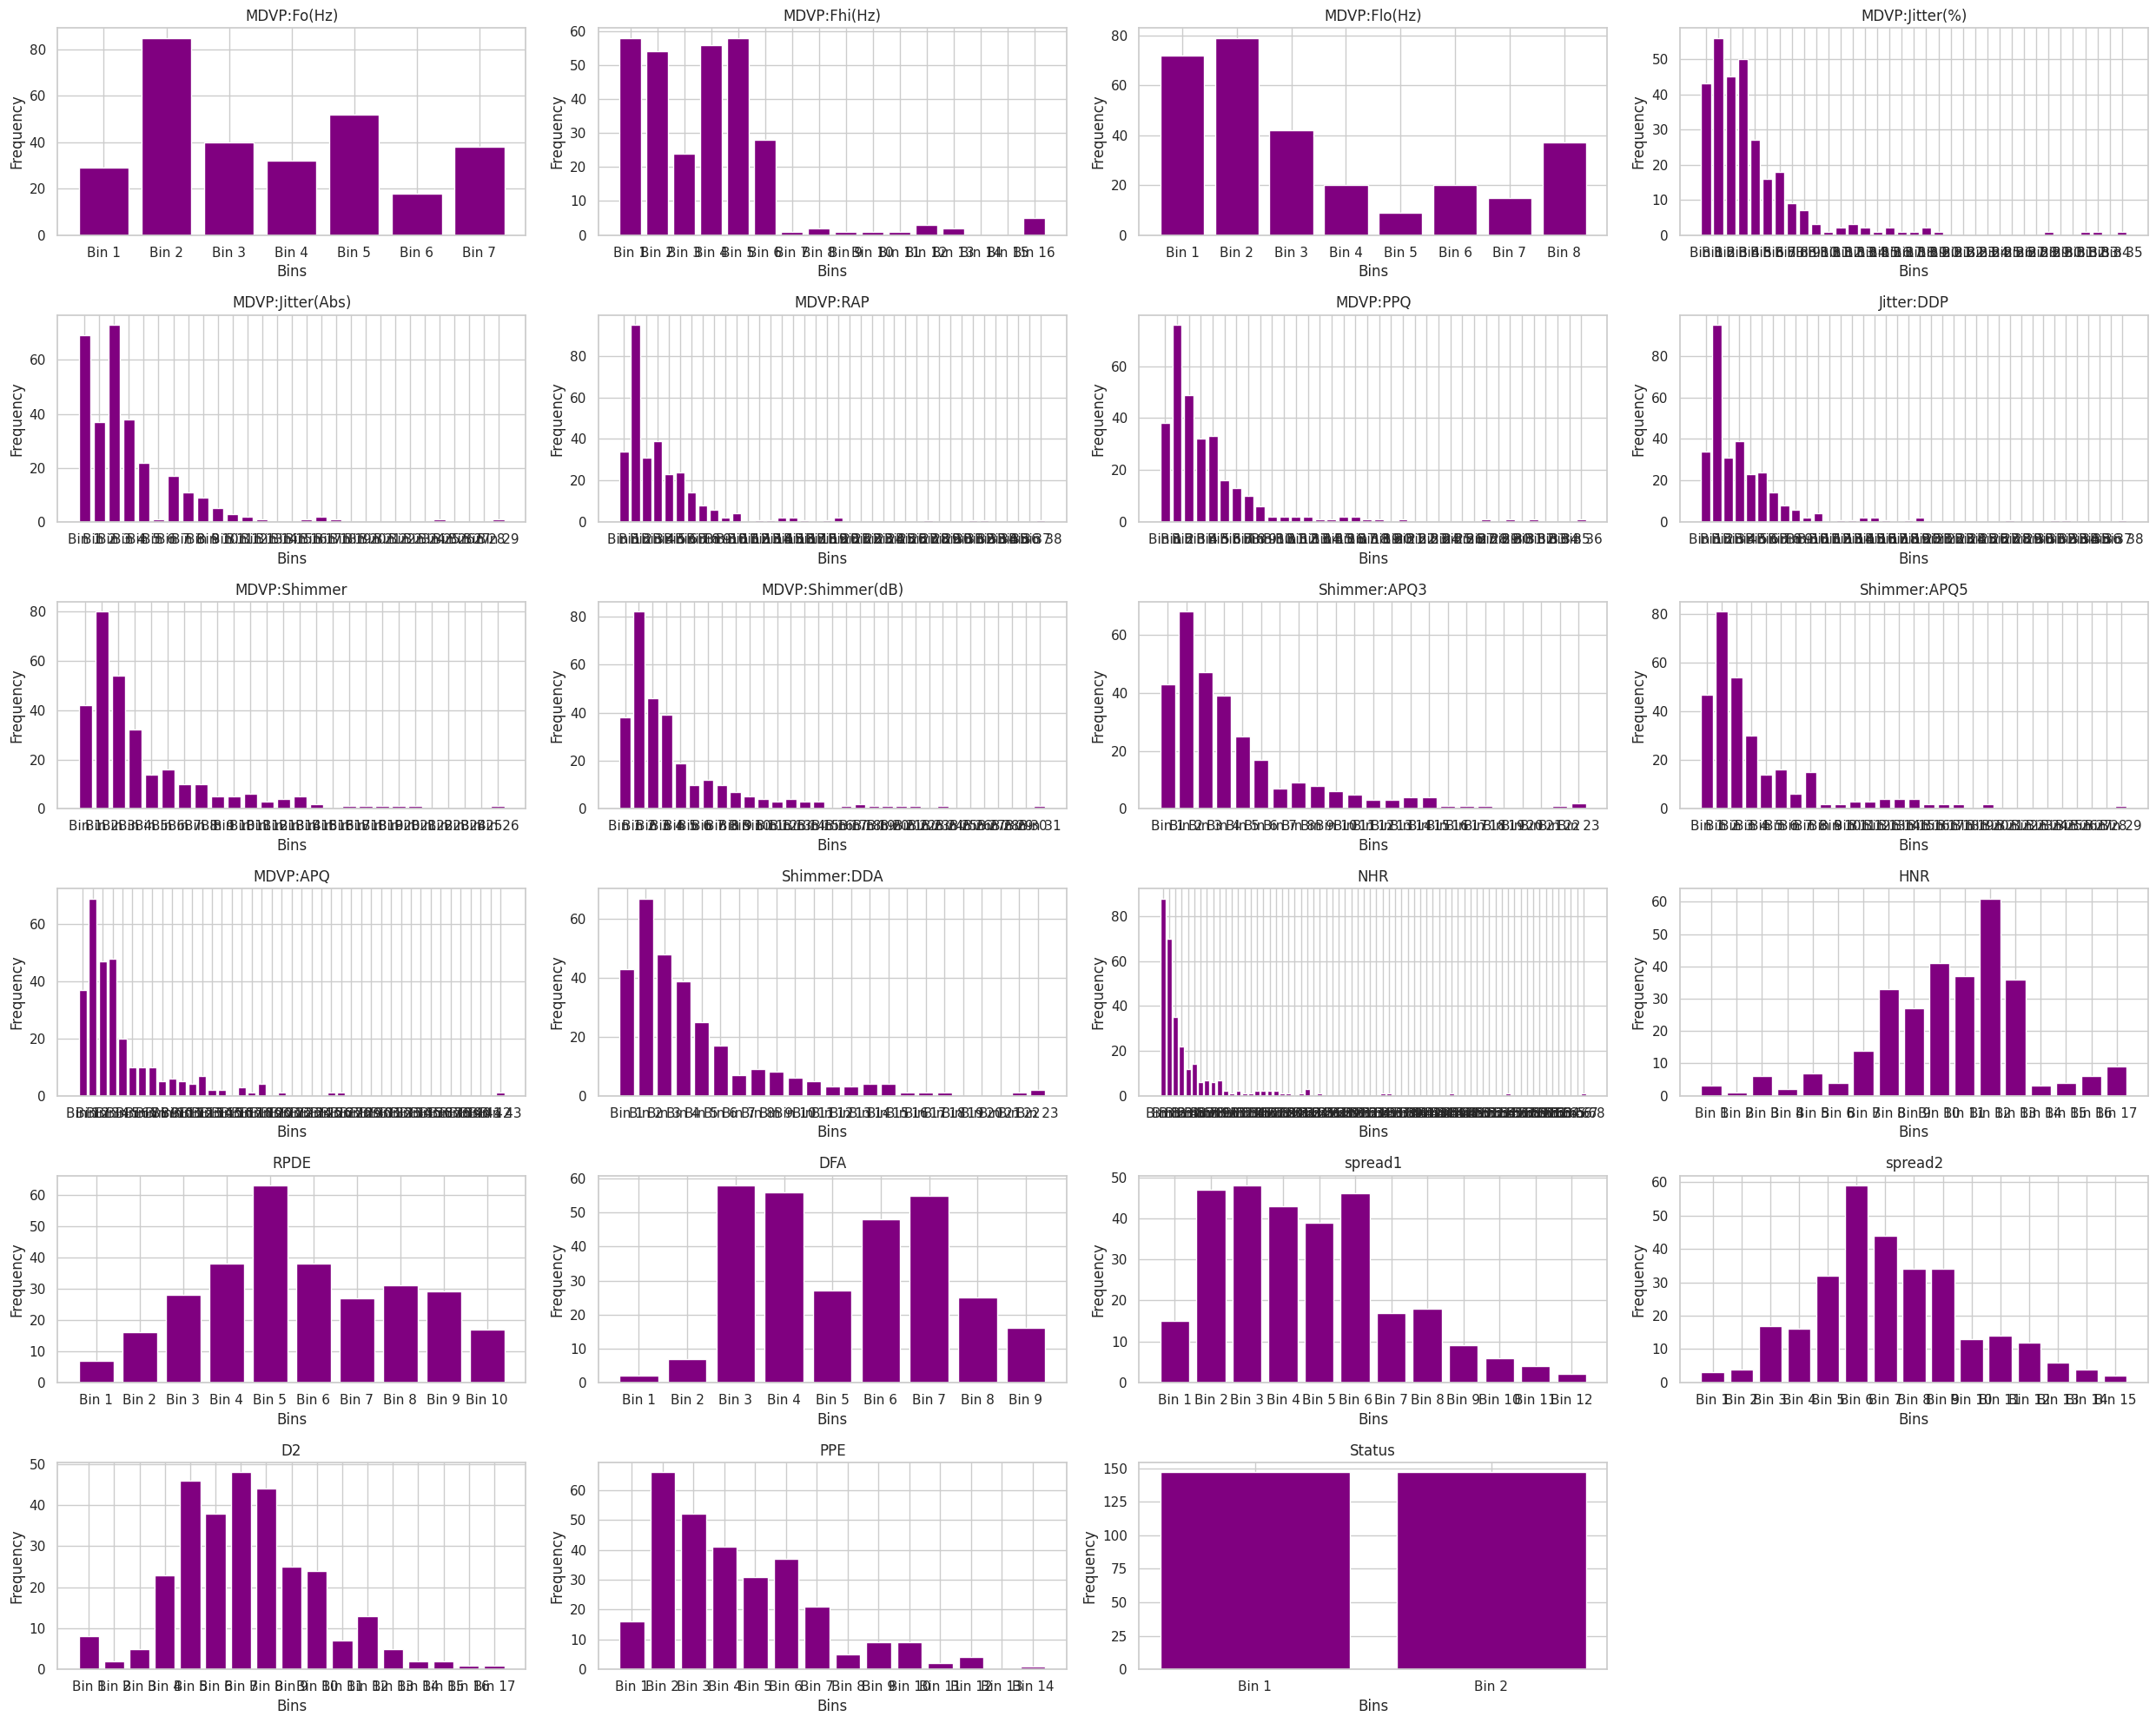

In [42]:
plot_bins_barcharts(parkinsons_df_freedman_diaconis)

### Comparing Discretisation Methods
---

In [43]:
mse_5bins = mean_squared_error(parkinsons_df, parkinsons_df_5bins)
mse_sturges = mean_squared_error(parkinsons_df, parkinsons_df_sturges)
mse_freedman_diaconis = mean_squared_error(parkinsons_df, parkinsons_df_freedman_diaconis)

In [44]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

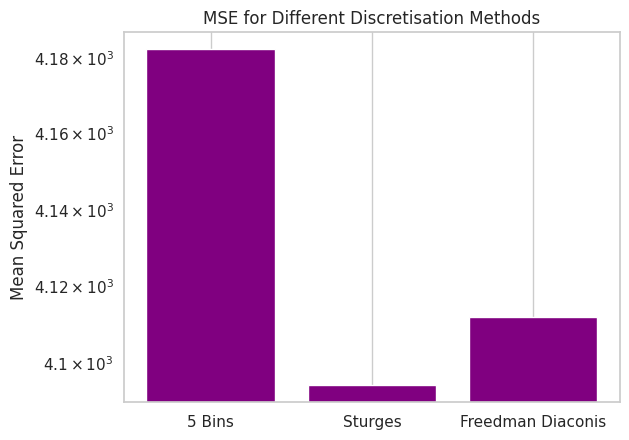

In [45]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

This time it seems that the Sturges method performs better, so we will use that.

In [46]:
parkinsons_df = parkinsons_df_sturges.copy()
parkinsons_df.describe().T

count  unique  top  freq
MDVP:Fo(Hz)         294      10    1    76
MDVP:Fhi(Hz)        294       9    0    93
MDVP:Flo(Hz)        294      10    2    65
MDVP:Jitter(%)      294       8    0   168
MDVP:Jitter(Abs)    294       9    0   179
MDVP:RAP            294       9    0   193
MDVP:PPQ            294       9    0   179
Jitter:DDP          294       9    0   193
MDVP:Shimmer        294       9    0   160
MDVP:Shimmer(dB)    294       9    0   169
Shimmer:APQ3        294       9    0   127
Shimmer:APQ5        294       8    0   178
MDVP:APQ            294       8    0   208
Shimmer:DDA         294       9    0   127
NHR                 294       8    0   247
HNR                 294      10    6    84
RPDE                294      10    4    63
DFA                 294      10    3    52
spread1             294      10    1    66
spread2             294      10    3    76
D2                  294      10    3    72
PPE                 294      10    1    90
Status              294       2    0   147

## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In [47]:
evaluation = {}

#### Tree-Augmented Naive Bayes
---

In [48]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Status'}

##### Bayes

In [49]:
evaluation_tan_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.20154620640057533 | 0.14352602197010625 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16432937792161093 | 0.13056005762650819 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.09313196691837469 | 0.1192148388258599  |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.0915138439410284  | 0.11111111111111112 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 295.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 413.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 224.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.09it/s]

[bnlearn]> Remaining columns for inference: 22



100%|██████████| 1/1 [00:00<00:00, 308.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.56it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.19145855953673543 | 0.13938092682054035 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16702859211002533 | 0.1377706208624083  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09699601882012306 | 0.1200572553229558  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.09211002533478103 | 0.11039541957416354 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 316.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 207.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.69it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.2025089605734767  | 0.15049683830171634 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16218637992831542 | 0.12773261065943994 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.0960573476702509  | 0.12122854561878953 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.09121863799283154 | 0.11472448057813912 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 232.80it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.18it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 216.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 229.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 236.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 202.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 208.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 191.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 222.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 208.46it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 214.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 230.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 224.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 195.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 192.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 211.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 216.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.21it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 211.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 186.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 210.34it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(0) | 0.23504968383017166 | 0.1492831541218638  |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(1) | 0.12935862691960257 | 0.13799283154121864 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(2) | 0.0935862691960253  | 0.12670250896057347 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(3) | 0.0903342366757001  | 0.10734767025089606 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 340.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 430.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 425.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.29it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.47it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 414.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 212.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.08it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.2054034711039542  | 0.14887082204155375 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16514582215065307 | 0.12610659439927732 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09268205403471104 | 0.11960252935862692 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.08946144211844695 | 0.11635049683830172 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 393.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 443.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 222.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.44it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.89it/s]


In [50]:
evaluation['Tree-Augmented Naive Bayes (Bayes)'] = evaluation_tan_bayes

##### Maximum Likelihood

In [51]:
evaluation_tan_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+----------------------+
| Status          | Status(0)           | Status(1)            |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(0) | 0.5847457627118644  | 0.28205128205128205  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(1) | 0.3898305084745763  | 0.21367521367521367  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(2) | 0.01694915254237288 | 0.15384615384615385  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(3) | 0.00847457627118644 | 0.1111111111111111   |
+-----------------+---------------------+---------

100%|██████████| 1/1 [00:00<00:00, 343.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 444.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 413.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.47it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+----------------------+----------------------+
| Status         | Status(0)            | Status(1)            |
+----------------+----------------------+----------------------+
| Shimmer:DDA(0) | 0.543859649122807    | 0.256198347107438    |
+----------------+----------------------+----------------------+
| Shimmer:DDA(1) | 0.41228070175438597  | 0.24793388429752067  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(2) | 0.03508771929824561  | 0.15702479338842976  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(3) | 0.008771929824561403 | 0.10743801652892562  |
+----------------+----------------------+----------

100%|██████████| 1/1 [00:00<00:00, 399.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 199.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 429.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.27it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(0) | 0.5833333333333334   | 0.3217391304347826   |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(1) | 0.375                | 0.2                  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(2) | 0.03333333333333333  | 0.16521739130434782  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(3) | 0.008333333333333333 | 0.13043478260869565  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 358.76it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.79it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 222.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 432.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.90it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 234.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 422.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.37it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 241.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.51it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(0) | 0.7739130434782608   | 0.30833333333333335  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(1) | 0.20869565217391303  | 0.25                 |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(2) | 0.017391304347826087 | 0.19166666666666668  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(3) | 0.0                  | 0.09166666666666666  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 322.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 440.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 221.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.68it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 436.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.77it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 391.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 425.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 433.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.47it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+----------------------+
| Status         | Status(0)           | Status(1)            |
+----------------+---------------------+----------------------+
| Shimmer:DDA(0) | 0.5950413223140496  | 0.3130434782608696   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(1) | 0.3884297520661157  | 0.19130434782608696  |
+----------------+---------------------+----------------------+
| Shimmer:DDA(2) | 0.01652892561983471 | 0.1565217391304348   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(3) | 0.0                 | 0.1391304347826087   |
+----------------+---------------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 334.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 223.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 429.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.73it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.80it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.99it/s]


In [52]:
evaluation['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = evaluation_tan_ml

#### Hill Climbing
---

In [53]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [54]:
evaluation_hc_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.20154620640057533 | 0.14352602197010625 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16432937792161093 | 0.13056005762650819 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.09313196691837469 | 0.1192148388258599  |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.0915138439410284  | 0.11111111111111112 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 300.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 220.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 234.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 215.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 212.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.25it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.19145855953673543 | 0.13938092682054035 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16702859211002533 | 0.1377706208624083  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09699601882012306 | 0.1200572553229558  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.09211002533478103 | 0.11039541957416354 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 372.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 435.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 377.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 251.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.76it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.2025089605734767  | 0.15049683830171634 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16218637992831542 | 0.12773261065943994 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.0960573476702509  | 0.12122854561878953 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.09121863799283154 | 0.11472448057813912 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 291.55it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.48it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 427.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.99it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.62it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 224.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.87it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(0) | 0.23504968383017166 | 0.1492831541218638  |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(1) | 0.12935862691960257 | 0.13799283154121864 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(2) | 0.0935862691960253  | 0.12670250896057347 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(3) | 0.0903342366757001  | 0.10734767025089606 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 300.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 214.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.39it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.66it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 424.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 365.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.05it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.2054034711039542  | 0.14887082204155375 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16514582215065307 | 0.12610659439927732 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09268205403471104 | 0.11960252935862692 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.08946144211844695 | 0.11635049683830172 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 324.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 187.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.61it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.14it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.79it/s]


In [55]:
evaluation['BDeu Hill Climbing (Bayes)'] = evaluation_hc_bayes

##### Maximum Likelihood

In [56]:
evaluation_hc_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+----------------------+
| Status          | Status(0)           | Status(1)            |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(0) | 0.5847457627118644  | 0.28205128205128205  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(1) | 0.3898305084745763  | 0.21367521367521367  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(2) | 0.01694915254237288 | 0.15384615384615385  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(3) | 0.00847457627118644 | 0.1111111111111111   |
+-----------------+---------------------+---------

100%|██████████| 1/1 [00:00<00:00, 337.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 445.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 233.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 224.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 186.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 373.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.77it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.71it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+----------------------+----------------------+
| Status         | Status(0)            | Status(1)            |
+----------------+----------------------+----------------------+
| Shimmer:DDA(0) | 0.543859649122807    | 0.256198347107438    |
+----------------+----------------------+----------------------+
| Shimmer:DDA(1) | 0.41228070175438597  | 0.24793388429752067  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(2) | 0.03508771929824561  | 0.15702479338842976  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(3) | 0.008771929824561403 | 0.10743801652892562  |
+----------------+----------------------+----------

100%|██████████| 1/1 [00:00<00:00, 319.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 212.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 205.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.20it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.07it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(0) | 0.5833333333333334   | 0.3217391304347826   |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(1) | 0.375                | 0.2                  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(2) | 0.03333333333333333  | 0.16521739130434782  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(3) | 0.008333333333333333 | 0.13043478260869565  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 336.06it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.28it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 422.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.90it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.67it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 424.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 410.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.49it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(0) | 0.7739130434782608   | 0.30833333333333335  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(1) | 0.20869565217391303  | 0.25                 |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(2) | 0.017391304347826087 | 0.19166666666666668  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(3) | 0.0                  | 0.09166666666666666  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 337.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 446.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 414.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.31it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.91it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 430.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 192.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 439.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.92it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+----------------------+
| Status         | Status(0)           | Status(1)            |
+----------------+---------------------+----------------------+
| Shimmer:DDA(0) | 0.5950413223140496  | 0.3130434782608696   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(1) | 0.3884297520661157  | 0.19130434782608696  |
+----------------+---------------------+----------------------+
| Shimmer:DDA(2) | 0.01652892561983471 | 0.1565217391304348   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(3) | 0.0                 | 0.1391304347826087   |
+----------------+---------------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 366.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 239.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 208.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 367.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 434.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 219.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 399.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.40it/s]

[bnlearn]> Remaining columns for inference: 22



  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.42it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 242.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.33it/s]


In [57]:
evaluation['BDeu Hill Climbing (Maximum Likelihood)'] = evaluation_hc_ml

#### PC Algorithm
---

In [58]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [59]:
evaluation_pc_bayes = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.20154620640057533 | 0.14352602197010625 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16432937792161093 | 0.13056005762650819 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.09313196691837469 | 0.1192148388258599  |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.0915138439410284  | 0.11111111111111112 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 352.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 309.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 388.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 336.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 255.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 384.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 289.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 205.37it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.19145855953673543 | 0.13938092682054035 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16702859211002533 | 0.1377706208624083  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09699601882012306 | 0.1200572553229558  |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.09211002533478103 | 0.11039541957416354 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 321.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 225.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 271.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.68it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 167.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 223.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 254.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 187.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 333.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 403.34it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(0) | 0.2025089605734767  | 0.15049683830171634 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(1) | 0.16218637992831542 | 0.12773261065943994 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(2) | 0.0960573476702509  | 0.12122854561878953 |
+-----------------+---------------------+---------------------+
| Shimmer:APQ3(3) | 0.09121863799283154 | 0.11472448057813912 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 387.39it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.86it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 380.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 371.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 424.95it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 238.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.20it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 331.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 222.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 425.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 356.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.99it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+---------------------+---------------------+
| Status          | Status(0)           | Status(1)           |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(0) | 0.23504968383017166 | 0.1492831541218638  |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(1) | 0.12935862691960257 | 0.13799283154121864 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(2) | 0.0935862691960253  | 0.12670250896057347 |
+-----------------+---------------------+---------------------+
| MDVP:Shimmer(3) | 0.0903342366757001  | 0.10734767025089606 |
+-----------------+---------------------+----------------

100%|██████████| 1/1 [00:00<00:00, 242.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 392.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 318.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 306.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 229.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 278.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.99it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 250.83it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 296.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.25it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 294.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 374.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 231.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 248.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.17it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 314.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.76it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+---------------------+
| Status         | Status(0)           | Status(1)           |
+----------------+---------------------+---------------------+
| Shimmer:DDA(0) | 0.2054034711039542  | 0.14887082204155375 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(1) | 0.16514582215065307 | 0.12610659439927732 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(2) | 0.09268205403471104 | 0.11960252935862692 |
+----------------+---------------------+---------------------+
| Shimmer:DDA(3) | 0.08946144211844695 | 0.11635049683830172 |
+----------------+---------------------+---------------------+
| Shi

100%|██████████| 1/1 [00:00<00:00, 277.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 264.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 311.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 411.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 237.53it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 321.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 247.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 431.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 347.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 284.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 390.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.66it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.90it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 219.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.59it/s]


In [60]:
evaluation['PC Algorithm (Bayes)'] = evaluation_pc_bayes

##### Maximum Likelihood

In [61]:
evaluation_pc_ml = discrete_cross_validation(parkinsons_df, 'Status', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+---------------------+----------------------+
| Status          | Status(0)           | Status(1)            |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(0) | 0.5847457627118644  | 0.28205128205128205  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(1) | 0.3898305084745763  | 0.21367521367521367  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(2) | 0.01694915254237288 | 0.15384615384615385  |
+-----------------+---------------------+----------------------+
| Shimmer:APQ3(3) | 0.00847457627118644 | 0.1111111111111111   |
+-----------------+---------------------+---------

100%|██████████| 1/1 [00:00<00:00, 336.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 397.15it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.61it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 398.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 400.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 302.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 405.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 389.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 395.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 379.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 275.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 243.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 245.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 256.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 378.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 183.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 317.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 416.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 229.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 268.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 216.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.00it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 285.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 209.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.56it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 413.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 353.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 334.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 316.81it/s]



Fold 2/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+----------------------+----------------------+
| Status         | Status(0)            | Status(1)            |
+----------------+----------------------+----------------------+
| Shimmer:DDA(0) | 0.543859649122807    | 0.256198347107438    |
+----------------+----------------------+----------------------+
| Shimmer:DDA(1) | 0.41228070175438597  | 0.24793388429752067  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(2) | 0.03508771929824561  | 0.15702479338842976  |
+----------------+----------------------+----------------------+
| Shimmer:DDA(3) | 0.008771929824561403 | 0.10743801652892562  |
+----------------+----------------------+----------

100%|██████████| 1/1 [00:00<00:00, 418.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 227.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 259.36it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 246.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.74it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 362.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 412.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.96it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 344.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 260.66it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 409.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 386.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 270.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 319.40it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 385.72it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 335.44it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 252.43it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 328.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 387.18it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 283.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.47it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 423.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 312.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 401.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 298.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 407.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 228.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 223.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.62it/s]



Fold 3/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:APQ3:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(0) | 0.5833333333333334   | 0.3217391304347826   |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(1) | 0.375                | 0.2                  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(2) | 0.03333333333333333  | 0.16521739130434782  |
+-----------------+----------------------+----------------------+
| Shimmer:APQ3(3) | 0.008333333333333333 | 0.13043478260869565  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 416.47it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 119 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
119            4             1             4               4   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
119                 3         3         4           3             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
119                 6  ...            6    2    1     7    8        8   

     spread2  D2  PPE  Status  
119        9   8    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 287.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 261.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.14it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 123 in fold 3: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
123            5             2             4               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
123                 1         1         1           1             3   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
123                 2  ...            3    2    1     7    6        6   

     spread2  D2  PPE  Status  
123        8   9    5       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 320.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 274.51it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.37it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 266.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 267.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 292.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 354.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.11it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 305.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.06it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 293.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.26it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 323.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 263.83it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 369.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.27it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 232.01it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 244.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.35it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 150 in fold 3: KeyError - 8
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
150            2             9             0               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
150                 8         8         8           8             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
150                 6  ...            9    8    0     7    2        8   

     spread2  D2  PPE  Status  
150        5   5    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.13it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 288.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.85it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 421.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.23it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.15it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 166 in fold 3: KeyError - 6
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
166            3             1             4               0   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
166                 0         0         0           0             6   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
166                 5  ...            7    0    4     5    5        2   

     spread2  D2  PPE  Status  
166        4   4    1       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:APQ3', 'Shimmer:DDA', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:Fo(Hz)', 'Jitter:DDP', 'MDVP:Jitter(%)', 'NHR', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'RPDE', 'spread2', 'D2', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'PPE', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 381.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 341.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 345.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.69it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 279.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.16it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 280.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 326.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.78it/s]



Fold 4/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of MDVP:Shimmer:
+-----------------+----------------------+----------------------+
| Status          | Status(0)            | Status(1)            |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(0) | 0.7739130434782608   | 0.30833333333333335  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(1) | 0.20869565217391303  | 0.25                 |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(2) | 0.017391304347826087 | 0.19166666666666668  |
+-----------------+----------------------+----------------------+
| MDVP:Shimmer(3) | 0.0                  | 0.09166666666666666  |
+-----------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 353.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.70it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 240.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 262.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 257.75it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 393.35it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.12it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 322.99it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 249.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 324.46it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 272.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 276.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 396.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 297.22it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.21it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 417.84it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.08it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 200 in fold 4: KeyError - 5
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
200            3             5             0               1   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
200                 1         0         1           0             0   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
200                 0  ...            0    0    5     7    2        4   

     spread2  D2  PPE  Status  
200        5   3    3       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.82it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 348.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.34it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 299.06it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 207 in fold 4: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
207            6             2             6               8   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
207                 5         7         8           7             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
207                 7  ...            7    5    0     7    7        9   

     spread2  D2  PPE  Status  
207        7   7    8       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['MDVP:Shimmer', 'Shimmer:APQ3', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR', 'MDVP:Fo(Hz)', 'MDVP:RAP', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread1', 'D2', 'spread2', 'Jitter:DDP', 'MDVP:Jitter(%)', 'PPE', 'RPDE', 'MDVP:PPQ', 'MDVP:Jitter(Abs)', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 332.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 329.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.52it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 350.93it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 445.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.05it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 265.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.38it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 360.89it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 303.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 404.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 357.48it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 368.54it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 295.87it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 358.55it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 363.33it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.19it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 340.58it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 307.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 338.39it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 415.94it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 352.97it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 310.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.76it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 428.03it/s]



Fold 5/5
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/253.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Shimmer:DDA:
+----------------+---------------------+----------------------+
| Status         | Status(0)           | Status(1)            |
+----------------+---------------------+----------------------+
| Shimmer:DDA(0) | 0.5950413223140496  | 0.3130434782608696   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(1) | 0.3884297520661157  | 0.19130434782608696  |
+----------------+---------------------+----------------------+
| Shimmer:DDA(2) | 0.01652892561983471 | 0.1565217391304348   |
+----------------+---------------------+----------------------+
| Shimmer:DDA(3) | 0.0                 | 0.1391304347826087   |
+----------------+---------------------+---------------------

100%|██████████| 1/1 [00:00<00:00, 261.90it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 300.04it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.63it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 339.29it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 277.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 315.31it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 364.79it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 327.07it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 313.50it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 375.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 359.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 346.49it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 216.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 269.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 253.45it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 258.08it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.14it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 349.64it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.92it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 337.03it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.60it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 291.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 406.62it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 370.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 383.88it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 402.41it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 372.30it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 419.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 376.24it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 351.81it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 408.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 290.65it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 426.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 418.76it/s]

[bnlearn]> Remaining columns for inference: 22



100%|██████████| 1/1 [00:00<00:00, 294.73it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 382.10it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 330.42it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 308.86it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 325.95it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 301.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 273.78it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 235.98it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 286.59it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 281.91it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.57it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 361.02it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 304.80it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 366.09it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 343.32it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 282.71it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 355.36it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 289 in fold 5: KeyError - 9
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
289            6             2             5               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
289                 6         8         9           8             9   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
289                 9  ...            9    6    0     8    7        9   

     spread2  D2  PPE  Status  
289        9   7    9       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 420.82it/s]


[bnlearn]> Remaining columns for inference: 22


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 291 in fold 5: KeyError - 7
Row causing error:      MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
291            2             0             2               9   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
291                 9         9         7           9             7   

     MDVP:Shimmer(dB)  ...  Shimmer:DDA  NHR  HNR  RPDE  DFA  spread1  \
291                 6  ...            9    9    0     9    3        7   

     spread2  D2  PPE  Status  
291        5   6    6       1  

[1 rows x 23 columns]
Model state names for target variable: {'Status': [0, 1]}
Model nodes: ['Shimmer:DDA', 'Shimmer:APQ3', 'MDVP:Shimmer', 'HNR', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:Fo(Hz)', 'spread1', 'MDVP:PPQ', 'NHR', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'DFA', 'spread2', 'PPE', 'RPDE', 'MDVP:Jitter(%)', 'D2', 'MDVP:RAP', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'Status']
[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 342.28it/s]


[bnlearn]> Remaining columns for inference: 22


100%|██████████| 1/1 [00:00<00:00, 394.46it/s]


In [62]:
evaluation['PC Algorithm (Maximum Likelihood)'] = evaluation_pc_ml

## Evaluation
---

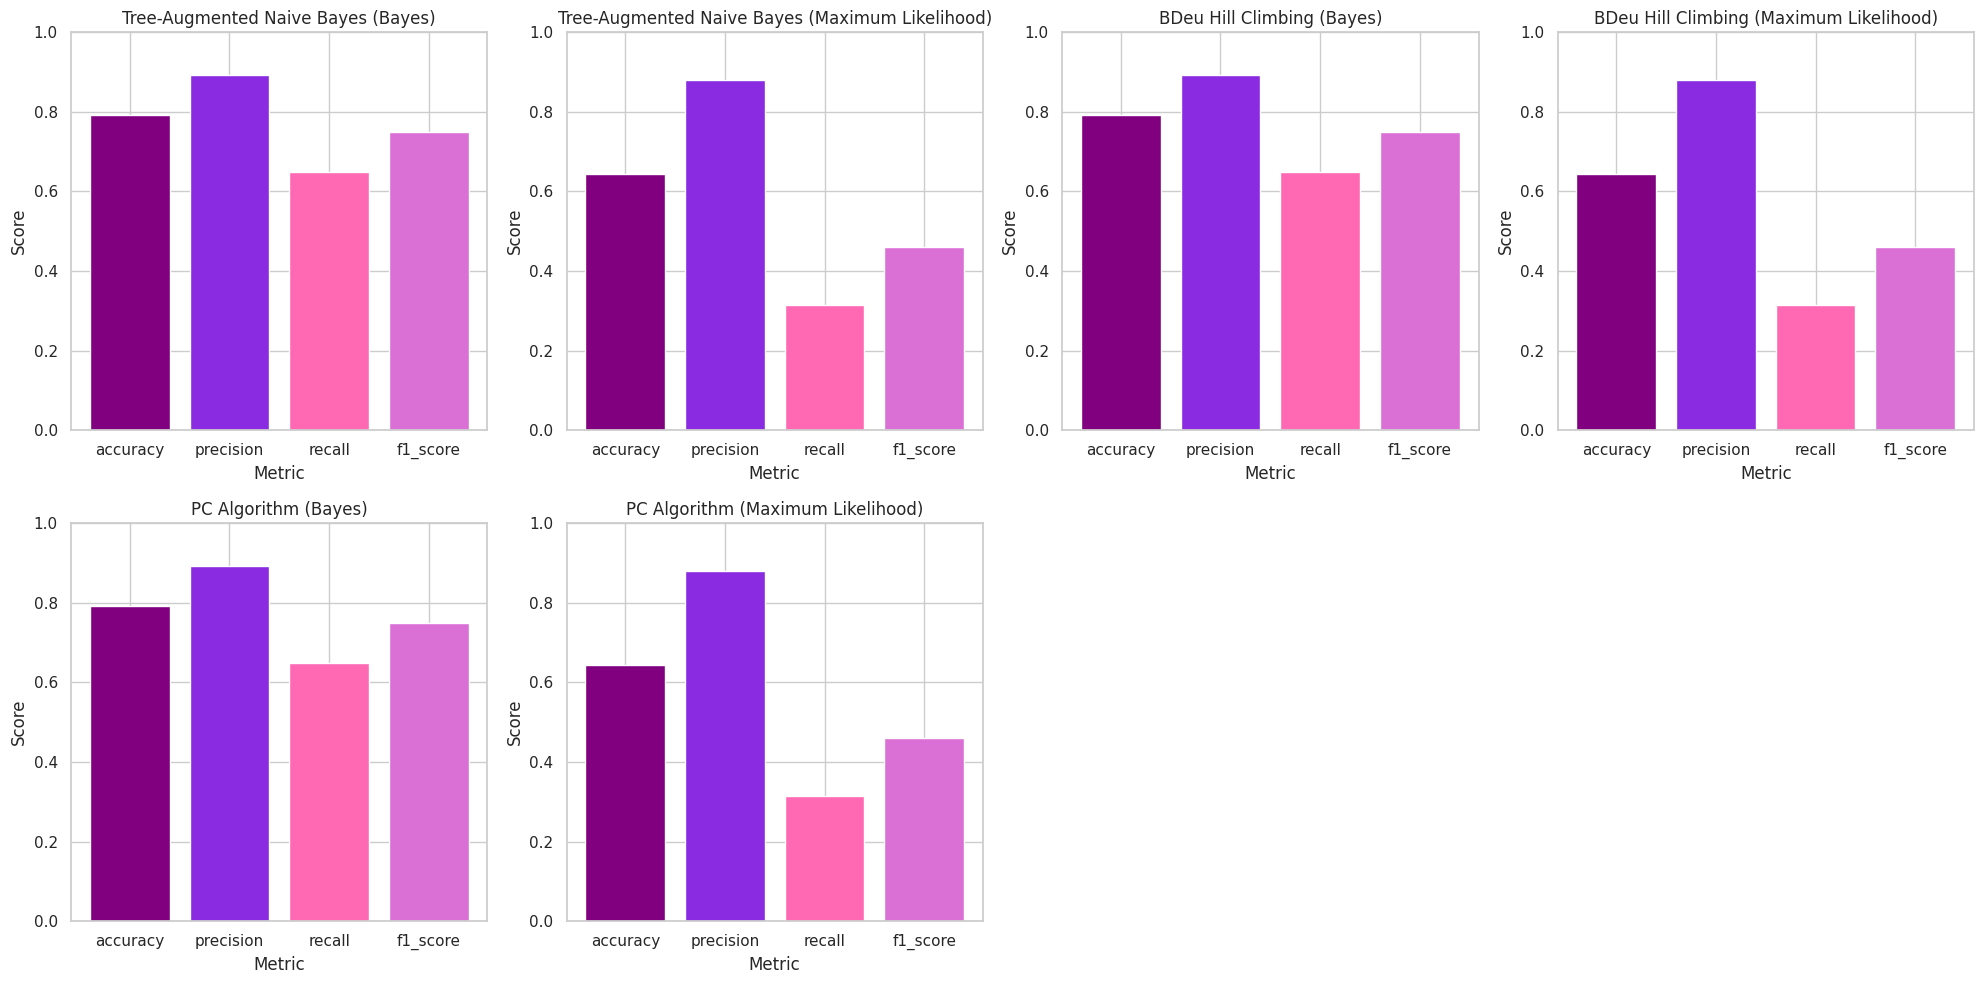

In [63]:
plot_metrics_from_evaluation(evaluation)

In [64]:
display_evaluation_results(evaluation)


Tree-Augmented Naive Bayes (Bayes):
  Metrics:
    Classification:
      Accuracy: 79.15%
      Precision: 89.30%
      Recall: 64.79%
      F1_score: 75.06%
    Roc_auc: 0.7874958507950487
    Brier_score: 0.20853999498314355
    Log_loss: 7.516543296940656
  Time Taken: 48.43 seconds
  Confusion Matrix: [135  12]
                    [44 95]

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Metrics:
    Classification:
      Accuracy: 64.43%
      Precision: 87.89%
      Recall: 31.39%
      F1_score: 46.08%
    Roc_auc: 0.635602393220427
    Brier_score: 0.3556900431067776
    Log_loss: 12.82036862770083
  Time Taken: 7.65 seconds
  Confusion Matrix: [139   8]
                    [94 45]

BDeu Hill Climbing (Bayes):
  Metrics:
    Classification:
      Accuracy: 79.15%
      Precision: 89.30%
      Recall: 64.79%
      F1_score: 75.06%
    Roc_auc: 0.7874958507950487
    Brier_score: 0.20853999498314355
    Log_loss: 7.516543296940656
  Time Taken: 36.36 seconds
  Confusion Matrix

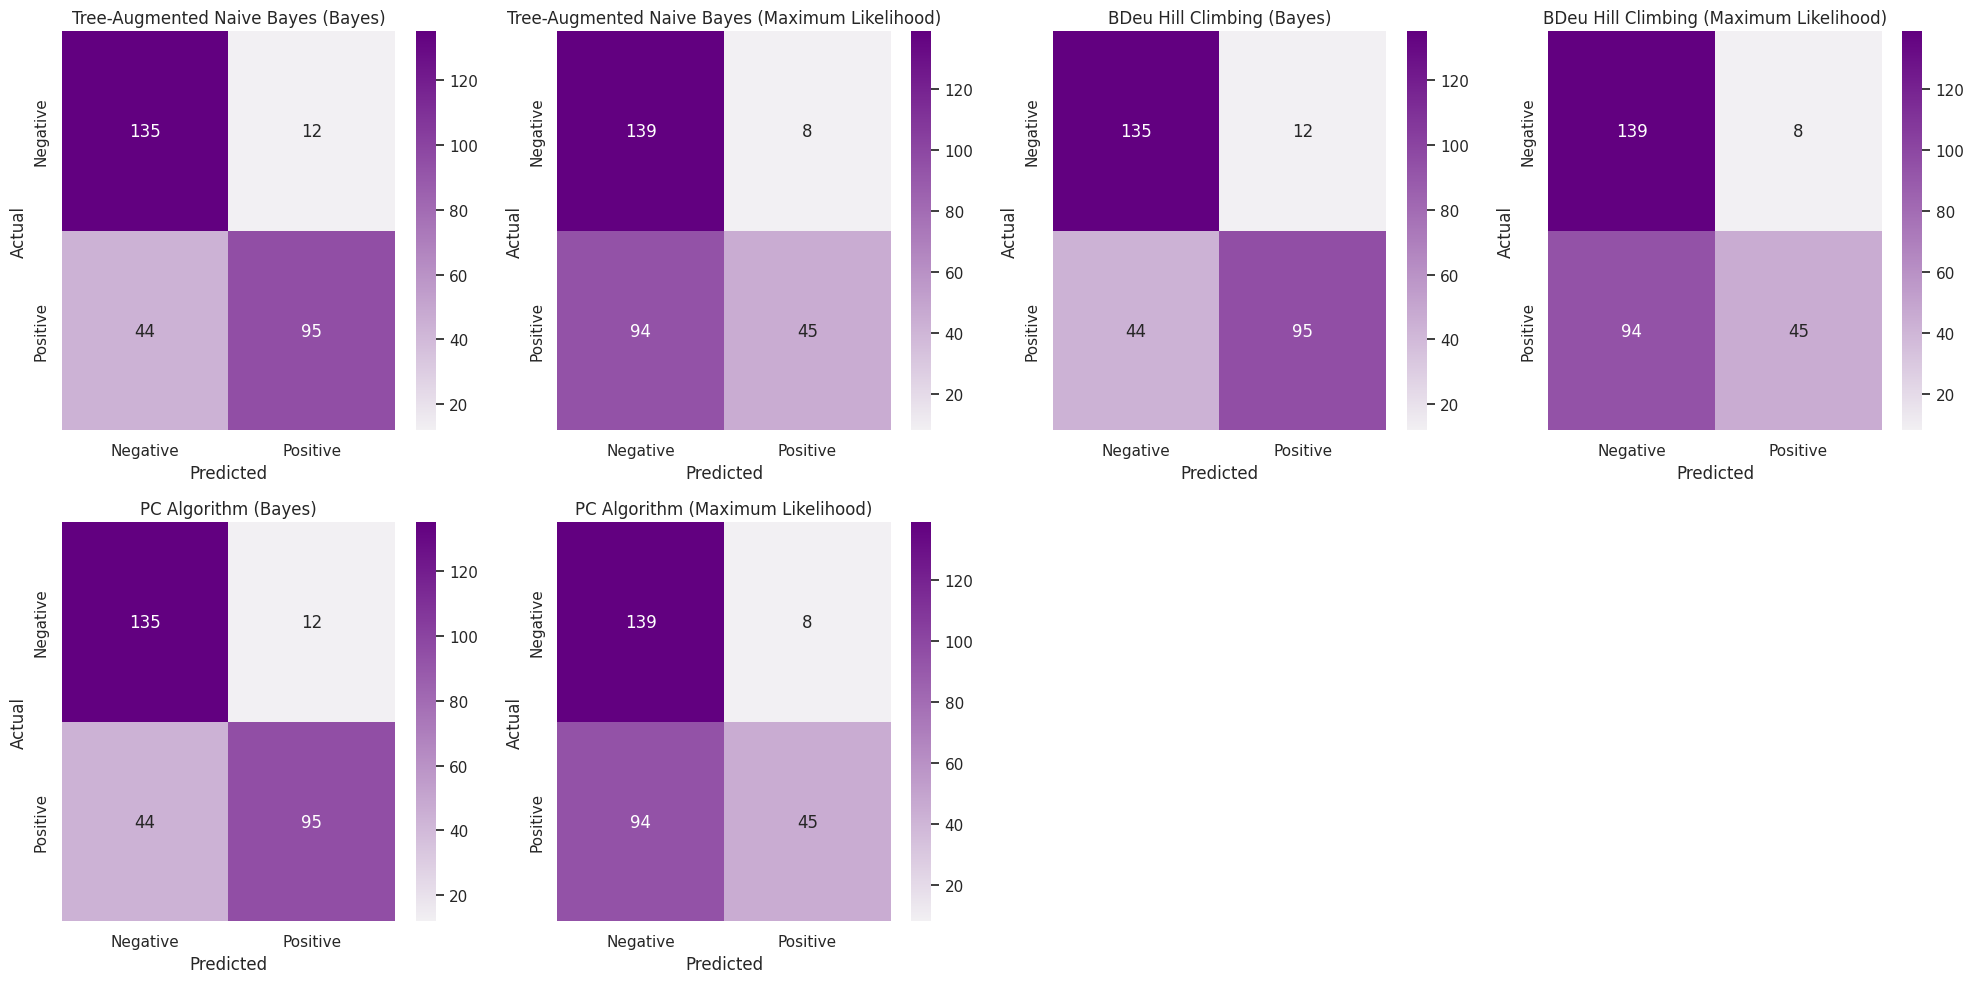

In [65]:
plot_confusion_matrices_from_evaluation(evaluation, cmap=gradient_palette)